<a href="https://colab.research.google.com/github/JadeBenson/Wikipedia_DeepLearning/blob/main/word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Notebook From Thinking with Deep Learning: Week 5 Part 1
# Deep Learning for Text

This notebook will implement the data we've collected for our final project: analyzing movie wikipedia information and posters. Primarily focused on neural word embeddings. 

#### imports and installations

In [1]:
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
!pip install -U yellowbrick # just so we can compare to the tester dataset
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-x_n8fxgl
  Running command git clone -q https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-x_n8fxgl
     |████████████████████████████████| 5.6 MB 6.5 MB/s 
     |████████████████████████████████| 117 kB 44.4 MB/s 
     |████████████████████████████████| 181 kB 45.7 MB/s 
     |████████████████████████████████| 76 kB 2.3 MB/s 
     |████████████████████████████████| 132 kB 48.7 MB/s 
     |████████████████████████████████| 32.8 MB 1.5 MB/s 
     |████████████████████████████████| 8.8 MB 45.6 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 43.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 5.1 MB 8.0 MB/s 
     |███████████████

In [2]:
import lucem_illud
import gensim
import pandas as pd
import numpy as np
import re
import sklearn
import spacy

Let's also load the spacy English Language model, which we draw upon.

In [3]:
nlp = spacy.load("en")

In [4]:
# generally not good practice, as we want to see warnings - but in this case, there are no critical warnings
import warnings
warnings.filterwarnings('ignore')

# Precursors and Diagnostics for Deep Neural Networks

Before diving into using deep neural models for text, it is useful to have an idea what your textual data looks like. This process of exploratory data analysis (EDA) can be done in many ways - we will explore some of the more popular approaches, some of which you've seen in our earlier notebook on representations of text data. 

NOTE: usually, we are running deep neural methods on very large bodies of text. Some of the methods we will be exploring in this section are optimized for small to medium bodies of text; we recommend you sample from your very large datasets and explore these methods.

In [ ]:
## CMU Wikipedia movie dataset 

#first use "Movie meta data"
#Movie name, release data, genres, wikipedia movie ID 
#use wikipedia movie ID to link with the plot summaries in plot_summaries.txt

movie_info = pd.read_csv('movie.metadata.tsv', sep = '\t', header = None)
movie_info.columns = ["wiki_ID", "freebase_ID", "title", "date", "revenue", "runtime", "language", "country", "genres"]

#lowercase titles, no spaces or punctuation to hopefully make matching easier 

clean_titles = lambda x: re.sub(r'[^a-z\d]', '', x.lower())
movie_info['match_title'] = movie_info["title"].apply(clean_titles)

## We can read in the cleaned up data (saved from an earlier iteration of this notebook)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
movie_info_plots = pd.read_csv("/content/drive/MyDrive/naive_genre_movies.csv", index_col =0)
#movie_info_plots.to_csv("/content/drive/MyDrive/naive_genre_movies.csv")

In [ ]:
sum_movie_plots = movie_info_plots['plot'].sum()

In [ ]:
len(movie_info_plots)

27270

In [ ]:
movie_info_plots.columns

Index(['wiki_ID', 'freebase_ID', 'title', 'date', 'revenue', 'runtime',
       'language', 'country', 'genres', 'match_title', 'plot', 'clean_genres',
       'one_genre'],
      dtype='object')

In [88]:
mini_movie_info_plots = movie_info_plots.sample(n=400).reset_index(drop=True)

In [ ]:
len(mini_movie_info_plots) #len(corpus.data)

400

In [89]:
mini_movie_info_plots.columns

Index(['wiki_ID', 'freebase_ID', 'title', 'date', 'revenue', 'runtime',
       'language', 'country', 'genres', 'match_title', 'plot', 'clean_genres',
       'one_genre'],
      dtype='object')

In [90]:
mini_movie_info_plots['title'][0] #corpus.data[0]

'Bye Bye Brasil'

In [91]:
mini_movie_info_plots['plot'][0] #corpus.data[0]

"A traveling sideshow made up of a magician, a strongman, and an exotic dancer stop in rural villages hoping to mesmerize the townspeople out of whatever little money they may have. When a young accordionist becomes enamoured with the show's exotic dancer, he and his pregnant wife join the show as it sets off deeper into the interior."

In [92]:
mini_movie_info_plots['one_genre'][0] #corpus.target[0]

'Drama'

In [9]:
action_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Action']
adventure_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Adventure']
comedy_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Comedy']
documentary_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Documentary']
drama_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Drama']
horror_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Horror']
romcom_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Romantic comedy']
scifi_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Science Fiction']
thriller_movies = movie_info_plots[movie_info_plots['one_genre'] == 'Thriller']

In [ ]:
for item in [action_movies, adventure_movies, comedy_movies, documentary_movies, drama_movies, horror_movies, romcom_movies, scifi_movies, thriller_movies]:
  print(len(item))

1594
909
3112
685
8874
1387
1329
997
4109


# Neural Embeddings

We'll now start using neural networks - not explicitly, by building models using Keras and PyTorch, but by using different tricks in training models, we can get a network to end up learning different useful notions of semantics - we then use this model's final embedding (or other aspect) to extract useful features for our text data.

## Shallow Neural Embeddings

Word2vec, much like methods like LSA which we saw earlier, is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window. 
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another. 

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away. 

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included. 

The code below has two examples, one for loading a pre-trained word2vec model, and one for training our own model, with an explanation of the hyperparameters. 




In [ ]:
mini_movie_info_plots['plot']

0      Drawn from the play of the same name by Maurin...
1      A young man  goes to Heaven and steps before S...
2      The beginning of the special introduces the Co...
3      In an interview with Anime News Network, Kon t...
4      Wyoming ranch hand Vern Haskell is enraged whe...
                             ...                        
395    Cheech & Chong's Next Movie opens with both me...
396    In 1992, Bogota, Colombia, a man named Fabio ,...
397    A very disfigured Paul  escapes from the creek...
398    Anna Völkl, the fiance of taxidermist Frank Wy...
399    Abner Procane hires Raymond St. Ives, a crime ...
Name: plot, Length: 400, dtype: object

## When running on larger corpus: Change the value below

In [ ]:
MOVIE_DF = movie_info_plots

### Training Word Embeddings

In the first example, we train a word2vec model on the hobbies dataset with a dimension size of 100 and window of 10, meaning the context window is 10 words. The training process goes through 10 iterations.



In [10]:
from gensim.parsing.preprocessing import preprocess_documents
from gensim.corpora import Dictionary
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Here, pre-processed texts is a file we created for our topic models, and includes stemmed words. This is a useful exercise to see how pre-processing effects word2vec models. Recall from earlier sections (and homeworks) that the deeper the model the less pre-processing we need to perform because the model can be trained to perform optimal processing.

NOTE: if using gensim v3.8.3, use "size" for dimension size, and if using v4 +, use "vector_size".

In [ ]:
def create_w2vec_model_lemm(corpus_df, model_title):
  '''
  This model does a FULL TEXT PREPROCESSING (using gensim.parsing and gensim.corpora)
  includes lemmatizing
  '''
  dictionary = Dictionary(preprocessed_texts)
  corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]
  w2vmodel_cleaned = Word2Vec(
        preprocessed_texts,
        size=100,
        window=10)
  w2vmodel_cleaned.save("/content/drive/MyDrive/" + model_title)

In [ ]:
'''create_w2vec_model_lemm(documentary_movies, 'docu_w2v.model')'''

In [ ]:
documentary_movies_w2v_model = Word2Vec.load("/content/drive/MyDrive/docu_w2v.model")

Let's test the model by looking up some words that we know are in the corpus and find similar words.

In [ ]:
documentary_movies_w2v_model.wv.most_similar("book")

[('chang', 0.9999566078186035),
 ('begin', 0.9999545812606812),
 ('famili', 0.9999531507492065),
 ('creat', 0.9999529719352722),
 ('claim', 0.9999504089355469),
 ('time', 0.9999501705169678),
 ('camera', 0.9999500513076782),
 ('help', 0.999949038028717),
 ('like', 0.9999487996101379),
 ('histori', 0.9999483823776245)]

In [ ]:
documentary_movies_w2v_model.wv.most_similar("talk")

[('awai', 0.9999418258666992),
 ('return', 0.9999361038208008),
 ('make', 0.9999358654022217),
 ('death', 0.9999346137046814),
 ('discov', 0.9999323487281799),
 ('call', 0.9999322295188904),
 ('plan', 0.9999313950538635),
 ('find', 0.9999310970306396),
 ('friend', 0.9999310970306396),
 ('live', 0.9999297857284546)]

NOTE: it may soon become clear in the next section, but it isn't the best idea to use a corpus with stop words removed. Following from above, we lose a lot of potential relationships we can learn automatically!

We don't always need to train our own models. One of the advantages of word embedding (and many deep learning) models is using pre-trained models, where the training has already been completed on a large and/or representative corpus or document collection. In the following lines of code we load either a [Google News model](https://drive.google.com/file/d/1TW3h1SIx__4Y6zEzLnrPry2Z-6BZgtyh/view?usp=sharing) (3+ GB), or a [model trained on NY Times data](https://drive.google.com/file/d/1xrs1UhTH5LPTBFLcflX-nQ86zwCAoLt5/view?usp=sharing) (30 MB). If you have Colab Pro, you can try the heavier model. I have used the mounting capacity on google drive here. You can also just upload the file if you prefer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
model_address = "/content/drive/MyDrive/nytimes_cbow.reduced.txt" 
#model_address = "nytimes_cbow.reduced.txt" 

In [28]:
nytimes_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address)

In [ ]:
nytimes_w2v_model.most_similar("book")

[('book,', 0.807381272315979),
 ('books', 0.7208226919174194),
 ('memoir', 0.6905068755149841),
 ('novel', 0.6485089063644409),
 ('book.', 0.6376286745071411),
 ('biography', 0.6335103511810303),
 ('novel,', 0.6032705307006836),
 ('memoir,', 0.5900480151176453),
 ('novels', 0.5858581066131592),
 ('author', 0.5705239772796631)]

In [ ]:
nytimes_w2v_model.most_similar("talk")

[('talking', 0.6718707084655762),
 ('speak', 0.6052849292755127),
 ('talked', 0.5983412265777588),
 ('tell', 0.5425027012825012),
 ('conversation', 0.5362381935119629),
 ('hear', 0.5258073806762695),
 ('know', 0.5096373558044434),
 ('think', 0.4957665205001831),
 ('listen', 0.4826739430427551),
 ('discuss', 0.47418320178985596)]

Note how the most similar words make a lot more sense with the pre-trained, larger, ny times word2vec model. Also note what lemmatizing words can dramatically change the results of word2vec! Why? Because we are removing specificity in context that our model can otherwise learn. The smaller the corpus, the more useful to remove content (e.g., stem); the larger the corpus, the more useful to retain it.

Just so we have a comparison, we also create a non-cleaned corpus of the hobbies dataset on which to build an embedding model.

In [13]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation

In [ ]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
#CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

def word2vec_model(movie_df, output_filename, custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation]):
  '''
  This function only lowers text, strips tags and strips punctuation
  Whereas, the other one lemmatizes and does more text preprocessing
  '''
  tokenized_texts = []
  for text in movie_df['plot']:
    tokenized_texts.append(preprocess_string(text, custom_filters))
  w2vmodel = Word2Vec(tokenized_texts,
        size=300,
        window=10)
  w2vmodel.save("/content/drive/MyDrive/UChicago/Spring2022/word2vec_models/" + output_filename)

In [ ]:
'''
df_titles = [(action_movies, 'action_minimal_w2v.model'), (adventure_movies, 'adventure_minimal_w2v.model'), (comedy_movies, 'comedy_minimal_w2v.model'), (documentary_movies, 'documentary_minimal_w2v.model'), (drama_movies, 'drama_minimal_w2v.model'), (horror_movies, 'horror_minimal_w2v.model'), (romcom_movies, 'romcom_minimal_w2v.model'), (scifi_movies, 'scifi_minimal_w2v.model'), (thriller_movies, 'thriller_minimal_w2v.model')]
for movie_df, title in df_titles:
  word2vec_model(movie_df, title)
  print(title.split('_')[0], 'contains', len(movie_df), 'plots')
'''

action contains 1594 plots
adventure contains 909 plots
comedy contains 3112 plots
documentary contains 685 plots
drama contains 8874 plots
horror contains 1387 plots
romcom contains 1329 plots
scifi contains 997 plots
thriller contains 4109 plots


## We've saved the models so that this doesn't need to be run each time, now we can just load them in with the code below:


NOTE: if using gensim v3.8.3, use "size" for dimension size, and if using v4 +, use "vector_size"

## Word2Vec models have been created for each of the genres - can now import them:

In [16]:
def w2v_generator():
  for _, output_filename in df_titles:
    yield Word2Vec.load("/content/drive/MyDrive/UChicago/Spring2022/word2vec_models/" + output_filename)

In [21]:
[action_w2v, adventure_w2v, comedy_w2v, documentary_w2v, drama_w2v, horror_w2v, romcom_w2v, scifi_w2v, thriller_w2v] = [w2v_model for w2v_model in w2v_generator()]

### Word and Context Embeddings

The gensim model allows us to access both the target embedding for the word itself, and the context embedding for words. These two embedding are multiplied to recreate the original word space, revealing the way in which neural embeddings perform (and are optimized through) matrix factorization of the original word-by-context matrix. The target embedding is what is most commonly used, though in some cases the context is also used along with the target. We show how to use both.

The context vector is not showcased in the documentation - we unearthed it thanks to this helpful [StackOverflow link](https://stackoverflow.com/questions/39406092/how-to-get-both-the-word-embeddings-vector-and-context-vector-of-a-given-word-by).

In [24]:
word_of_interest = 'book'
model_of_interest = adventure_w2v

In [29]:
interest_embedding_ny = nytimes_w2v_model[word_of_interest]

In [31]:
interest_embedding = model_of_interest[word_of_interest]

In [32]:
interest_context_embedding = model_of_interest.wv.syn0[model_of_interest.wv.vocab[word_of_interest].index]

In [33]:
interest_context_embedding_ny = nytimes_w2v_model.wv.syn0[nytimes_w2v_model.wv.vocab[word_of_interest].index]

### Exploring Semantics with Embeddings

So what do these vectors encapsulate? We've seen before that it is some notion of meaning, as captured by distributional semantics, with some aspect of syntactic information. How do we then use these word embeddings? Because they capture semantic information in a space that allows for semantic decomposition, a common task is to perform semantic arithmetic and analogy tasks.


Find the word that least matches the others within a word set (cosine similarity).

In [40]:
nytimes_w2v_model.doesnt_match(['man', 'woman', 'affection', 'loving', 'teamwork', 'admiration'])

'man'

In [41]:
model_of_interest.doesnt_match(['man', 'woman', 'affection', 'loving', 'teamwork', 'admiration'])

'man'

We can also perform arithmetic on vectors using the most_similar function we saw earlier. One of the more popular, earlier examples demonstrating the analogous power of word2vec models was vector['king'] - vector['man'] + vector['woman'] = vector['queen'], where the idea is that we are traversing a "gender" dimension and looking at either end of it. 

Let's see how that works on our NY Times model.

In [42]:
model_of_interest.most_similar(positive=['king', 'woman'], negative = ['man'])

[('beautiful', 0.994138777256012),
 ('tale', 0.9941052198410034),
 ('ward', 0.9940165877342224),
 ('poisons', 0.9937665462493896),
 ('career', 0.9937630891799927),
 ('saruman', 0.9936928153038025),
 ('rosenblum', 0.9935330152511597),
 ('eldest', 0.9935135841369629),
 ('discusses', 0.993502676486969),
 ('infant', 0.9930791854858398)]

In [43]:
nytimes_w2v_model.most_similar(positive=['king', 'woman'], negative = ['man'])

[('royal', 0.5032206773757935),
 ('Queen', 0.464691162109375),
 ('Prince', 0.31866323947906494),
 ('King', 0.2965490221977234),
 ('birth', 0.2890930473804474),
 ('daughter', 0.27517256140708923),
 ('marry', 0.24971053004264832),
 ('birthday', 0.2484097182750702),
 ('minister.', 0.2482222020626068),
 ('mother.', 0.2480422854423523)]

If we shift ['king'] in the direction of woman, we get to ['royal']...and almost to ['queen'] (try adding woman twice!) Interestingly, ['prince'] is a similarly effeminate royal. We can begin to see the utility of these models, even if they do capture all semantic associations as we might imagine. Larger language models capture even more sophisticated relationships. 

In the rest of this section we will see other ways in which we can use and explore word embeddings.

### Visualising Word Embeddings

Most methods involving visualising word embeddings involve projecting words into a lower dimensional space and seeing which words appear nearby one another. 

See this [example by TTIC](https://home.ttic.edu/~kgimpel/wordembviz/wordembviz.html) which visualises different sets of word embeddings, using t-SNE.

The code below gives you an idea of how you might do it yourself.

In [44]:
import matplotlib.pyplot as plt

In [45]:
numWords = 50

In [46]:
targetWords = model_of_interest.wv.index2word[200: 200 + numWords]

In [47]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(model_of_interest[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.31617263, -0.49085614, -0.30786481, ...,  0.08369367,
        -0.32705262,  0.2656945 ],
       [-0.26505148, -0.5705132 , -0.2198915 , ..., -0.02985731,
        -0.2578602 ,  0.3584385 ],
       [-0.23280281, -0.47045517, -0.24807537, ..., -0.02716571,
        -0.3025942 ,  0.2762915 ],
       ...,
       [-0.20574161, -0.37941694, -0.18608877, ..., -0.00116593,
        -0.22813866,  0.1843745 ],
       [-0.271974  , -0.6178139 , -0.23631884, ..., -0.03028751,
        -0.27869087,  0.3657384 ],
       [-0.154921  , -0.45659637, -0.19271511, ..., -0.02196189,
        -0.21436131,  0.303191  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words. We also recommend exploring UMAP, which allows projections to any arbitrary number of dimensions.

In [48]:
import sklearn.decomposition
import sklearn.manifold

In [49]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

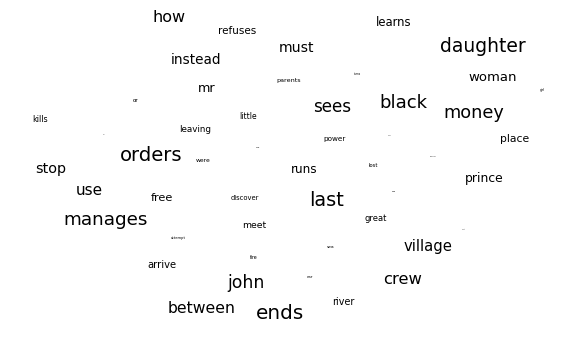

In [50]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Note how the TTIC projection was a lot more satisfactory because it projected related but differentiated words. Our example plots seemingly random words. We encourage that you try this example again with a curated list of words and see how the visualisation improves!

### Projecting Embeddings on Dimensions of Social Analysis

We can see how word2vec does remarkably well in capturing certain aspects of semantics! Word embeddings have a lot of utility outside of just looking at relations between words, though. Because words derive their meanings from various social characteristics and dimensions, it is possible for us to project word vectors onto word-defined dimensions to see where they lie. We can create these dimensions by choosing words which that might anchor the dimension and then project other words onto this dimension. For example, if we were trying to find a gender dimension, we might make a vector between the words he, him, man and she, her, woman, and so on. Then, with a cosine projection, we can get a value of where our word of choice might lie on this dimension, revealing to us how “gendered” the word is. The following snippets of code implements this for various such dimensions. Using such a technique for social scientific analysis as described by Kozlowski et al 2019; it can be very easily extended for many business and analytical solutions. 


First we can visualize with dimension reduction

In [59]:
#words to create dimensions
TargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
TargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in TargetWords:
  if word in model_of_interest.wv.vocab:
    wordsSubMatrix.append(model_of_interest[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [61]:
### Note: depending on the dimensions above- this number of components may need to be changed
pcaWords = sklearn.decomposition.PCA(n_components = 20).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

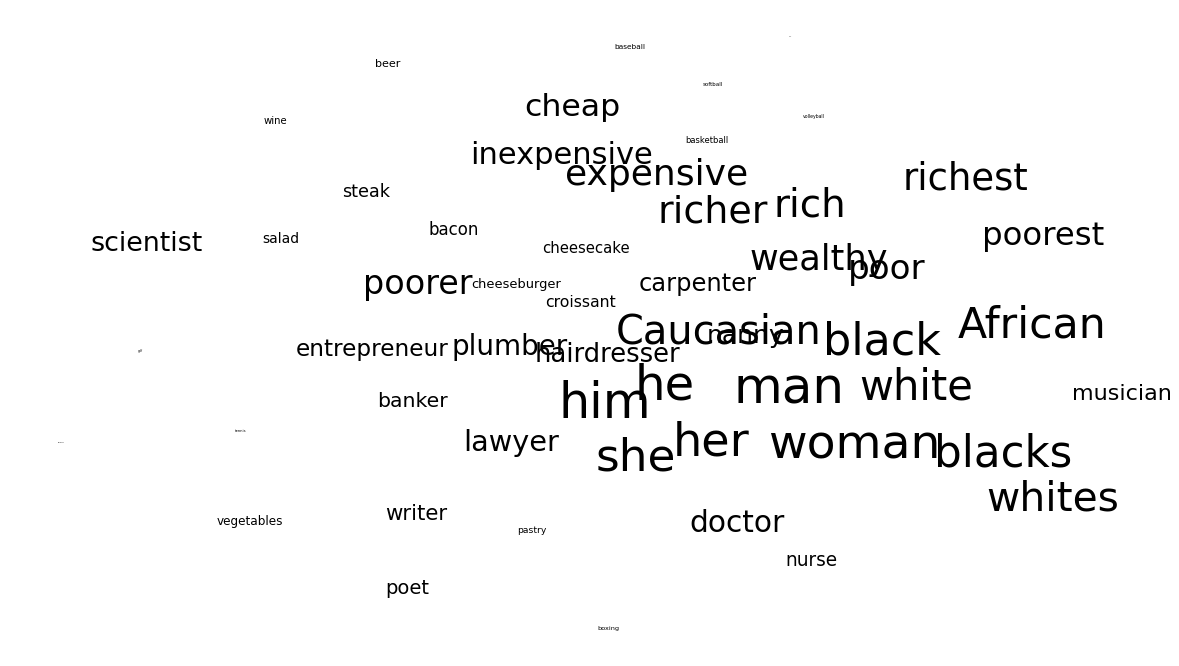

In [62]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible

for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
    
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [63]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [65]:
Gender = dimension(model_of_interest, ['man', 'male', 'boy','him','he'], ['woman', 'female', 'girl', 'her', 'she'])
#Race = dimension(MODEL_OF_INTEREST, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
#Class = dimension(MODEL_OF_INTEREST, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [66]:
Occupations = ["doctor","lawyer","scientist","nurse", "plumber","hairdresser","nanny","carpenter","entrepreneur","musician","writer","banker", "poet", ]
Foods = ["beer", "wine", "pastry"]
#"steak","bacon", "croissant", "cheesecake", "salad","cheeseburger", "vegetables",
Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

In [67]:
def checkout_model_words(model, test_list):
  for word in test_list:
    if word in model.wv.vocab:
      print('found', word, 'in model')
    else:
      print(word, 'is not in model')

In [68]:
checkout_model_words(model_of_interest, Occupations)

found doctor in model
found lawyer in model
found scientist in model
found nurse in model
plumber is not in model
hairdresser is not in model
nanny is not in model
carpenter is not in model
entrepreneur is not in model
found musician in model
found writer in model
found banker in model
poet is not in model


Define a function to project words in a word list to each of the three dimensions.

In [72]:
def makeDF_genderonly(model, word_list):
    g = []
    included_word_list = []
    for word in word_list:
      if word in model.wv.vocab:
        included_word_list.append(word)
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g}, index = included_word_list)
    return df

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections for the nytimes model.

In [73]:
OCCdf_nyt = makeDF_genderonly(nytimes_w2v_model, Occupations) 
#Fooddf = makeDF(nytimes_w2v_model, Foods)
#Sportsdf = makeDF(nytimes_w2v_model, Sports)

Get the projections for our models

In [77]:
action_OCCdf = makeDF_genderonly(action_w2v, Occupations) 
adventure_OCCdf = makeDF_genderonly(adventure_w2v, Occupations) 
comedy_OCCdf = makeDF_genderonly(comedy_w2v, Occupations) 
documentary_OCCdf = makeDF_genderonly(documentary_w2v, Occupations) 
drama_OCCdf = makeDF_genderonly(drama_w2v, Occupations) 
horror_OCCdf = makeDF_genderonly(horror_w2v, Occupations) 
romcom_OCCdf = makeDF_genderonly(romcom_w2v, Occupations) 
scifi_OCCdf = makeDF_genderonly(scifi_w2v, Occupations) 
thriller_OCCdf = makeDF_genderonly(thriller_w2v, Occupations) 


In [74]:
OCCdf = makeDF_genderonly(model_of_interest, Occupations) 
#Fooddf = makeDF_genderonly(MODEL_OF_INTEREST, Foods)
#Sportsdf = makeDF_genderonly(MODEL_OF_INTEREST, Sports)

Define some useful functions for plotting.

In [75]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

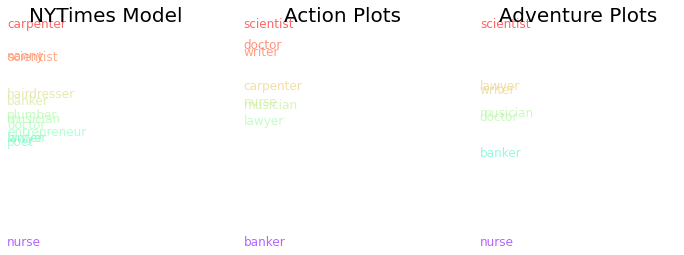

In [81]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf_nyt, 'gender')
ax1.title.set_text('NYTimes Model')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, action_OCCdf, 'gender')
ax2.title.set_text('Action Plots')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, adventure_OCCdf, 'gender')
ax3.title.set_text('Adventure Plots')

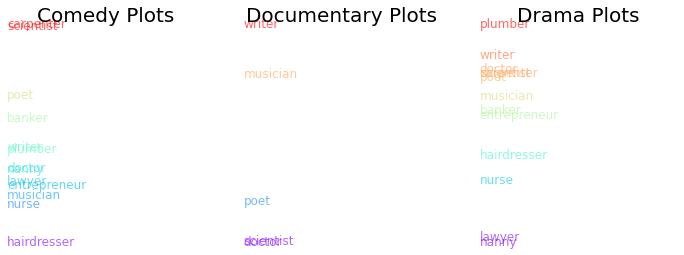

In [83]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, comedy_OCCdf, 'gender')
ax1.title.set_text('Comedy Plots')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, documentary_OCCdf, 'gender')
ax2.title.set_text('Documentary Plots')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, drama_OCCdf, 'gender')
ax3.title.set_text('Drama Plots')
#horror, romcom, scifi, thriller
plt.show()

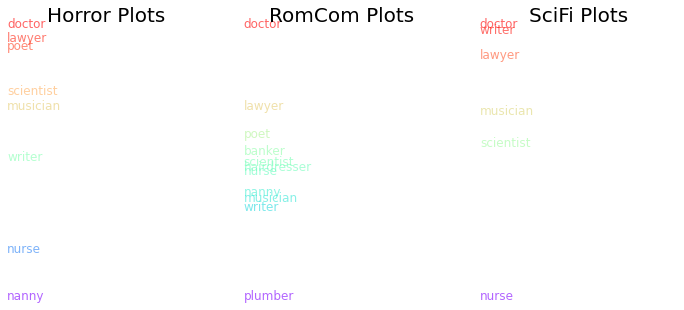

In [86]:
fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, horror_OCCdf, 'gender')
ax1.title.set_text('Horror Plots')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, romcom_OCCdf, 'gender')
ax2.title.set_text('RomCom Plots')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, scifi_OCCdf, 'gender')
ax3.title.set_text('SciFi Plots')
plt.show()

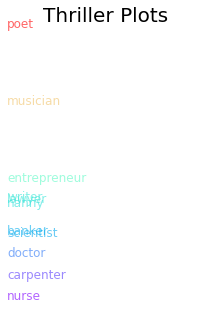

In [87]:
fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, thriller_OCCdf, 'gender')
ax1.title.set_text('Thriller Plots')
plt.show()

Foods:

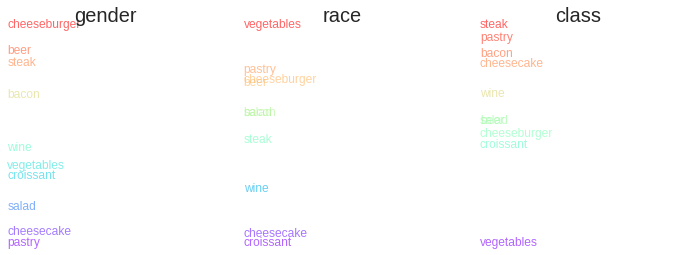

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

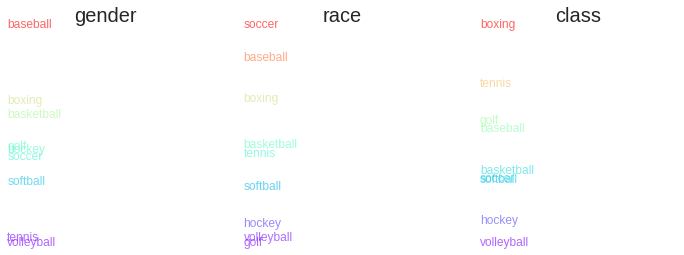

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

### Debiasing Word Embeddings

As we are creating these dimensions, it may become clear that such an approach may be adapted to measure socio-cultural biases in embeddings. Language models are trained on human generated corpora and text, so they end up reflecting the social and cultural biases present in text (Caliskan et al. 2017). Keeping in mind that the semantics we generate from natural language corpora reflect real world biases which may be harmful (for e.g, in the non modified,  biased models, man:computer programer:: woman:homemaker), there has been significant work in attempting to correct these biases (Bolukbasi et al 2016). These methods work similarly to the projection based methods we explored, and the following code includes code to debias embedding models so that generated associations (e.g., as in a job ad) do not propagate the bias.

In the following section, we use the code from this repository associated with the famous "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" paper: https://github.com/tolga-b/debiaswe


#### Hands-on Tutorial: Quantifying and Reducing Gender Stereotypes in Word Embeddings

Ensuring fairness in algorithmically-driven decision-making is important to avoid inadvertent cases of bias and perpetuation of harmful stereotypes. However, modern natural language processing techniques, which learn model parameters based on data, might rely on implicit biases presented in the data to make undesirable stereotypical associations. Such a danger faces us with word embeddings, a popular framework to represent text data as vectors which has been used in many machine learning and natural language processing tasks. Recent results ([1](https://arxiv.org/abs/1607.06520), [2](https://arxiv.org/abs/1608.07187)) show that word embeddings trained on a Google News articles exhibit extensive female/male gender stereotypes. This raises concerns because their widespread use may tend to amplify these biases. 

In the following, we provide step-by-step instructions to demonstrate and quanitfy the biases in word embedding.



In [ ]:
# Setup:
# Clone the code repository from https://github.com/tolga-b/debiaswe.git
# mkdir debiaswe_tutorial
# cd debiaswe_tutorial
# git clone https://github.com/tolga-b/debiaswe.git

# To reduce the time of downloading data, we provide as subset of GoogleNews-vectors in the following location:
# https://drive.google.com/file/d/1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG/view?usp=sharing

# For full embeddings:
# Download embeddings at https://github.com/tolga-b/debiaswe and put them on the following directory
# embeddings/GoogleNews-vectors-negative300-hard-debiased.bin
# embeddings/GoogleNews-vectors-negative300.bin

In [ ]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions

#### Part 1: Gender Bias in Word Embedding


##### Step 1: Load data
We first load the word embedding trained on a corpus of Google News texts consisting of 3 million English words and terms. The embedding maps each word into a 300-dimension vector. 

In [ ]:
# load google news word2vec
E = WordEmbedding('./embeddings/w2v_gnews_small.txt')

# load professions
professions = load_professions()
profession_words = [p[0] for p in professions]

*** Reading data from ./embeddings/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


#### Step 2: Define gender direction

We define gender direction by the direction of she - he because they are frequent and do not have alternative word senses (e.g., man can also refer to mankind). 

In [ ]:
# gender direction
v_gender = E.diff('she', 'he')

#### Step 3: Generating analogies of "Man: x :: Woman : y"

We show that the word embedding model generates gender-streotypical analogy pairs. 
To generate the analogy pairs, we use an analogy score defined in the paper mentioned above. This score finds word pairs well aligned with gender direction as well as within a short distance from each other to preserve topic consistency. 


In [ ]:
# analogies gender
a_gender = E.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender:
    print(a+"-"+b)

Computing neighbors
Mean: 10.2197328085
Median: 7.0
she-he
herself-himself
her-his
woman-man
daughter-son
businesswoman-businessman
girl-boy
actress-actor
chairwoman-chairman
heroine-hero
mother-father
spokeswoman-spokesman
sister-brother
girls-boys
sisters-brothers
queen-king
niece-nephew
councilwoman-councilman
motherhood-fatherhood
women-men
petite-lanky
ovarian_cancer-prostate_cancer
Anne-John
schoolgirl-schoolboy
granddaughter-grandson
aunt-uncle
matriarch-patriarch
twin_sister-twin_brother
mom-dad
lesbian-gay
husband-younger_brother
gal-dude
lady-gentleman
sorority-fraternity
mothers-fathers
grandmother-grandfather
blouse-shirt
soprano-baritone
queens-kings
Jill-Greg
daughters-sons
grandma-grandpa
volleyball-football
diva-superstar
mommy-kid
Sarah-Matthew
hairdresser-barber
softball-baseball
goddess-god
Aisha-Jamal
waitress-waiter
princess-prince
filly-colt
mare-gelding
ladies-gentlemen
childhood-boyhood
interior_designer-architect
nun-priest
wig-beard
granddaughters-grandsons
gi

#### Step 4: Analyzing gender bias in word vectors asscoiated with professions

Next, we show that many occupations are unintendedly associated with either male of female by projecting their word vectors onto the gender dimension. 

The script will output the profession words sorted with respect to the projection score in the direction of gender.

In [ ]:
# profession analysis gender
sp = sorted([(E.v(w).dot(v_gender), w) for w in profession_words])

sp[0:20], sp[-20:]

([(-0.23798442, u'maestro'),
  (-0.21665451, u'statesman'),
  (-0.20758669, u'skipper'),
  (-0.20267202, u'protege'),
  (-0.2020676, u'businessman'),
  (-0.19492392, u'sportsman'),
  (-0.18836352, u'philosopher'),
  (-0.1807366, u'marksman'),
  (-0.17289861, u'captain'),
  (-0.16785555, u'architect'),
  (-0.16702037, u'financier'),
  (-0.16313636, u'warrior'),
  (-0.15280862, u'major_leaguer'),
  (-0.15001445, u'trumpeter'),
  (-0.14718868, u'broadcaster'),
  (-0.14637242, u'magician'),
  (-0.14401694, u'fighter_pilot'),
  (-0.13782285, u'boss'),
  (-0.137182, u'industrialist'),
  (-0.13684885, u'pundit')],
 [(0.19714224, u'interior_designer'),
  (0.20833439, u'housekeeper'),
  (0.21560375, u'stylist'),
  (0.22363169, u'bookkeeper'),
  (0.23776126, u'maid'),
  (0.24125955, u'nun'),
  (0.24782579, u'nanny'),
  (0.24929334, u'hairdresser'),
  (0.24946158, u'paralegal'),
  (0.25276464, u'ballerina'),
  (0.25718823, u'socialite'),
  (0.26647124, u'librarian'),
  (0.27317622, u'receptionist

#### Practice

Repeat Step 2-4 with debiased word embedding. 

You can use debiaswe debias function to do the debiasing with word sets of your choosing

You can leave equalize_pairs and gender_specific_words blank when coming up with your own groups. We give an example for the case of gender below for you to warm up.

In [ ]:
from debiaswe.debias import debias

In [ ]:
# Lets load some gender related word lists to help us with debiasing
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [[u'woman', u'man'], [u'girl', u'boy'], [u'she', u'he'], [u'mother', u'father'], [u'daughter', u'son'], [u'gal', u'guy'], [u'female', u'male'], [u'her', u'his'], [u'herself', u'himself'], [u'Mary', u'John']]
gender specific 218 [u'actress', u'actresses', u'aunt', u'aunts', u'bachelor', u'ballerina', u'barbershop', u'baritone', u'beard', u'beards']


In [ ]:
debias(E, gender_specific_words, defs, equalize_pairs)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
set([(u'Dad', u'Mom'), (u'fathers', u'mothers'), (u'Gelding', u'Mare'), (u'twin_brother', u'twin_sister'), (u'HIMSELF', u'HERSELF'), (u'GRANDSONS', u'GRANDDAUGHTERS'), (u'KING', u'QUEEN'), (u'FRATERNITY', u'SORORITY'), (u'prince', u'princess'), (u'men', u'women'), (u'FATHERHOOD', u'MOTHERHOOD'), (u'Dudes', u'Gals'), (u'DADS', u'MOMS'), (u'BOYS', u'GIRLS'), (u'nephew', u'niece'), (u'Father', u'Mother'), (u'He', u'She'), (u'Grandfather', u'Grandmother'), (u'Spokesman', u'Spokeswoman'), (u'Brother', u'Sister'), (u'FATHERS', u'MOTHERS'), (u'UNCLE', u'AUNT'), (u'gelding', u'mare'), (u'Himself', u'Herself'), (u'his', u'her'), (u'Son', u'Daughter'), (u'prostate_cancer', u'ovarian_cancer'), (u'BROTHER', u'SISTER'), (u'chairman', u'chairwoman'), (u'MEN', u'WOMEN'), (u'gentlemen', u'ladies'), (u'SON', u'DAUGHTER'), (u'king', u'queen'), (u'Colt', u'Filly'), (u'councilman', u'councilwoman'), (u'SPOKESMAN', u'SPOKESWO

In [ ]:
# profession analysis gender
sp_debiased = sorted([(E.v(w).dot(v_gender), w) for w in profession_words])

sp_debiased[0:20], sp_debiased[-20:]

([(-0.41963255, u'congressman'),
  (-0.40675855, u'businessman'),
  (-0.32398781, u'councilman'),
  (-0.30967095, u'dad'),
  (-0.21665451, u'statesman'),
  (-0.11345412, u'salesman'),
  (-0.073004864, u'monk'),
  (-0.072163954, u'handyman'),
  (-0.049468268, u'minister'),
  (-0.043583866, u'archbishop'),
  (-0.040207233, u'bishop'),
  (-0.038332459, u'commissioner'),
  (-0.035724372, u'surgeon'),
  (-0.033134006, u'trader'),
  (-0.032377187, u'observer'),
  (-0.032095861, u'neurosurgeon'),
  (-0.031450123, u'priest'),
  (-0.031133929, u'skipper'),
  (-0.029659165, u'lawmaker'),
  (-0.029511193, u'commander')],
 [(0.029965654, u'teenager'),
  (0.030237058, u'instructor'),
  (0.030946141, u'student'),
  (0.031116983, u'paralegal'),
  (0.032039441, u'bookkeeper'),
  (0.032434631, u'cinematographer'),
  (0.034329094, u'graphic_designer'),
  (0.034705672, u'lifeguard'),
  (0.035666514, u'janitor'),
  (0.035971936, u'drummer'),
  (0.042120136, u'wrestler'),
  (0.043902256, u'hairdresser'),
 

In [ ]:
# analogies gender
a_gender_debiased = E.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender_debiased:
    print(a+"-"+b)

Computing neighbors
Mean: 10.2185974341
Median: 7.0
she-he
grandmother-grandfather
daughters-sons
women-men
princess-prince
mothers-fathers
females-males
woman-man
queen-king
councilwoman-councilman
gals-dudes
chairwoman-chairman
convent-monastery
female-male
granddaughters-grandsons
sorority-fraternity
moms-dads
niece-nephew
ovarian_cancer-prostate_cancer
grandma-grandpa
sisters-brothers
twin_sister-twin_brother
sister-brother
congresswoman-congressman
ex_boyfriend-ex_girlfriend
herself-himself
ladies-gentlemen
aunt-uncle
schoolgirl-schoolboy
businesswoman-businessman
motherhood-fatherhood
her-his
queens-kings
mother-father
granddaughter-grandson
spokeswoman-spokesman
mare-gelding
filly-colt
estrogen-testosterone
girls-boys
husbands-wives
daughter-son
girl-boy
mom-dad
actress-actor
lesbian-gay
compatriot-countryman
husband-younger_brother
gal-dude
hers-theirs
heroine-protagonist
feminism-feminist
actresses-actors
childhood-boyhood
waitress-waiter
kid-guy
me-him
mommy-daddy
aunts-uncle

### Retrofitting Word Vectors

We can debias word embeddings (or try to, at least) based on how we can move word vectors around in this high dimensional space. Word2vec and related methods are static in that they are trained only once and word vectors don’t change based on context. Nevertheless, research by (Faruqui et al. 2015) has shown that we can improve the performance of word embeddings on a series of tasks by retrofitting them, which involves using an external lexicon (collection of words) to move certain words closer together or farther apart. While the authors use this to improve performance on a series of semantic tasks, we can be creative in how we want to retrofit our embeddings. Below are instructions for performing this kind of task.

This is taken from the repository from the paper cited above: 
Retrofitting word vectors: https://github.com/mfaruqui/retrofitting

For the [retrofit.py](https://github.com/mfaruqui/retrofitting/blob/master/retrofit.py) file, use this link. The code is also copy pasted in the code cell below this.

#### Data you need

Word vector file
Lexicon file (provided here)
Each vector file should have one word vector per line as follows (space delimited):-

the -1.0 2.4 -0.3 ...

#### Running the program

python retrofit.py -i word_vec_file -l lexicon_file -n num_iter -o out_vec_file

python retrofit.py -i sample_vec.txt -l lexicons/ppdb-xl.txt -n 10 -o out_vec.txt

where, 'n' is an integer which specifies the number of iterations for which the optimization is to be performed. Usually n = 10 gives reasonable results.

#### Output File: out_vec.txt

which are your new retrofitted and (hopefully) improved word vectors, enjoy !



In [ ]:
import argparse
import gzip
import math
import numpy
import re
import sys

from copy import deepcopy

isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = numpy.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w')  
  for word, values in wordVectors.iteritems():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()
  
''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
  lexicon = {}
  for line in open(filename, 'r'):
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

''' Retrofit word vectors to a lexicon '''
def retrofit(wordVecs, lexicon, numIters):
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the data estimate if the number of neighbours
      newVec = numNeighbours * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight 1)
      for ppWord in wordNeighbours:
        newVec += newWordVecs[ppWord]
      newWordVecs[word] = newVec/(2*numNeighbours)
  return newWordVecs
  
if __name__=='__main__':

  parser = argparse.ArgumentParser()
  parser.add_argument("-i", "--input", type=str, default=None, help="Input word vecs")
  parser.add_argument("-l", "--lexicon", type=str, default=None, help="Lexicon file name")
  parser.add_argument("-o", "--output", type=str, help="Output word vecs")
  parser.add_argument("-n", "--numiter", type=int, default=10, help="Num iterations")
  args = parser.parse_args()

  wordVecs = read_word_vecs(args.input)
  lexicon = read_lexicon(args.lexicon)
  numIter = int(args.numiter)
  outFileName = args.output
  
  ''' Enrich the word vectors using ppdb and print the enriched vectors '''
  print_word_vecs(retrofit(wordVecs, lexicon, numIter), outFileName) 

### Aligning Word Embeddings

We've explored alignment in some detail in tutorial 2.2, on Data Integration and Alignment. Specifically, we looked at alignment across time and across languages -  in this section, we will revisit these examples.


NOTE: the following section has previously seen code.

#### Time based data

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists. You can download the data [here](https://drive.google.com/file/d/1R9EiThdJQ3vY84xcoPJGUBeqvemu_o8L/view?usp=sharing).

In [ ]:
ascoDF = pandas.read_csv("/content/ASCO_abstracts.csv", index_col=0)

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [ ]:
import copy

#### Cross Temporal Alignment

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic change as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In this case we train the models ourselves instead of using a pre-trained model, so this might take some time.

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [ ]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

This is the key to our aligning - the smart procrustes align method here is the one doing the aligning, and we are adding the alligned embeddings to the dictionary. 

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0][word].reshape(1, -1),
                                                                             embed[word].reshape(1, -1))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn

We now check certain words and see their movement in time along these abstracts.

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cats[0]][0][word].reshape(1, -1), embed[word].reshape(1, -1))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

In [ ]:
wordDivergences[:20]

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[2][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

We've seen here from a small, research based corpus how it is still able to capture some notion of semantic drift. The word cell has moved among the most and the word view has moved the least. We recommend trying similar analyses on different datasets to see how words change their meaning over time based on the company they keep. 

#### Cross language alignment

While in the previous example we saw how we can use a time-stamped textual corpus to create embeddings and then compare between them, in the following example we use pre-trained embeddings for different languages and align them using some powerful packages.

Here, we use Fast Text word embeddings downloaded from their [documentation website](https://fasttext.cc/), for Spanish and French embeddings. Fast Text does not take the word as a special unit but rather the character window, allowing it to achieve more subtle contextual information. You must download these embeddings and upload them to be able to complete this part of the exercise. Note that these files are large! If it doesn't work, restart your session, clear your uploads and try this section again.

We then perform an SVD and orthogonal transformation on the data to rotate and reflect it so that it best aligns. 
The code is adapted from:
https://github.com/babylonhealth/fastText_multilingual

In [ ]:
import io

In [ ]:
from fasttext import FastVector

In [ ]:
fr_dictionary = FastVector(vector_file='/content/wiki.fr.vec')


In [ ]:
es_dictionary = FastVector(vector_file='/content/wiki.es.vec')

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]

In [ ]:
print(FastVector.cosine_similarity(fr_vector, es_vector))

In [ ]:
# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

To align the two word embeddings, we must try and find some common words with similar meanings. Lets try this by simply going through some common dictionaries.

In [ ]:
es_words = set(es_dictionary.word2id.keys())
fr_words = set(fr_dictionary.word2id.keys())
overlap = list(es_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

In [ ]:
len(bilingual_dictionary)

In [ ]:
# form the training matrices
source_matrix, target_matrix = make_training_matrices(fr_dictionary, es_dictionary, bilingual_dictionary)

In [ ]:
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix)
fr_dictionary.apply_transform(transform)

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]
print(FastVector.cosine_similarity(fr_vector, es_vector))

Here, we see that by simply picking up words spelled the same, we have done a decent job in aligning the two spaces - the Spanish word for cat and French word for cat are closer than they were in the previously unaligned space. Try using an actual Spanish - French dictionary next time and see how well the embeddings end up aligning!


#### Deep Canonical Alignment

Aligning word embeddings is a popular task: here is some more material on aligning embeddings in different contexts, as well as a more efficient deep canonical alignment.

[Deep Canonical Alignment](http://proceedings.mlr.press/v28/andrew13.html)

https://github.com/Michaelvll/DeepCCA

https://github.com/mfaruqui/crosslingual-cca



In [ ]:
# code for deep CCA

### Dynamic Word Embeddings

While some temporal analysis with word embedding models create seperate embedding spaces for different time periods and align them, it is also possible to train all these embeddings in the same space, by assuming a _drift_ between each time period, simily to a dynamic topic model. Recently, it was shown in Bamler and Mandt (2017)(‘dynamic skip-gram’ model) and Yao et al. (2018) (‘dynamic Word2Vec’ model) that it is possible to learn the word embeddings across several time periods jointly, enforcing alignment across all of them simultaneously, and positioning all the models in the same vector space in one step.  This develops the idea of model alignment even further and eliminates the need to first learn separate embeddings for each time period, and then align subsequent model pairs. Of course, it also hides idiosyncratic differences between time periods.

- [Dynamic Word Embeddings for Evolving Semantic Discovery](https://arxiv.org/abs/1703.00607), Yao et al, [GitHub implementation](https://github.com/yifan0sun/DynamicWord2Vec)

- [Dynamic Word Embeddings](https://arxiv.org/pdf/1702.08359.pdf), Balmer and Mandt, [GitHub Implementation](https://github.com/accessai/dynamic_word_embeddings)

- [Dynamic Bernoulli Embeddings for Language Evolution](https://arxiv.org/abs/1703.08052), Rudolph and Blei, [GitHub Implementation](https://github.com/EvanZhuang/dynamic-clustering-of-dynamic-embeddings)

The code below implements a version of this.

The example input files can be downloaded at: [Dropbox link](
https://www.dropbox.com/s/nifi5nj1oj0fu2i/data.zip?dl=0)

The input is the word_pair_PMIs, which is stored in csvs (ignore the mat files); you need to put them all in a path and load everything from there (change the 'training head' variable). 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 13:10:42 2016

"""

# main script for time CD
# trainfile has lines of the form
# tok1,tok2,pmi

import numpy as np
import util_timeCD as util
import pickle as pickle

# PARAMETERS

nw = 20936 # number of words in vocab (11068100/20936 for ngram/nyt)
T = range(1990,2016) # total number of time points (20/range(27) for ngram/nyt)
cuda = True

trainhead = 'data/wordPairPMI_' # location of training data
savehead = 'results/'

def print_params(r,lam,tau,gam,emph,ITERS):

    print('rank = {}'.format(r))
    print('frob  regularizer = {}'.format(lam))
    print('time  regularizer = {}'.format(tau))
    print('symmetry regularizer = {}'.format(gam))
    print('emphasize param   = {}'.format(emph))
    print('total iterations = {}'.format(ITERS))

if __name__=='__main__':
    import sys
    ITERS = 5 # total passes over the data
    lam = 10 #frob regularizer
    gam = 100 # forcing regularizer
    tau = 50  # smoothing regularizer
    r   = 50  # rank
    b = nw # batch size
    emph = 1 # emphasize the nonzero

    foo = sys.argv
    for i in range(1,len(foo)):
        if foo[i]=='-r':    r = int(float(foo[i+1]))
        if foo[i]=='-iters': ITERS = int(float(foo[i+1]))
        if foo[i]=='-lam':    lam = float(foo[i+1])
        if foo[i]=='-tau':    tau = float(foo[i+1])
        if foo[i]=='-gam':    gam = float(foo[i+1])
        if foo[i]=='-b':    b = int(float(foo[i+1]))
        if foo[i]=='-emph': emph = float(foo[i+1])
        if foo[i]=='-check': erchk=foo[i+1]


    savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)

    print('starting training with following parameters')
    print_params(r,lam,tau,gam,emph,ITERS)
    print('there are a total of {} words, and {} time points'.format(nw,T))

    print('X*X*X*X*X*X*X*X*X')
    print('initializing')

    #Ulist,Vlist = util.initvars(nw,T,r, trainhead)
    Ulist,Vlist = util.import_static_init(T)
    print Ulist
    print Vlist
    asdf
    print('getting batch indices')
    if b < nw:
        b_ind = util.getbatches(nw,b)
    else:
        b_ind = [range(nw)]

    import time
    start_time = time.time()
    # sequential updates
    for iteration in xrange(ITERS):
        print_params(r,lam,tau,gam,emph,ITERS)
        try:
            Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )
            Vlist = pickle.load(open( "%sngV_iter%d.p" % (savefile, iteration), "rb" ) )
            print 'iteration %d loaded succesfully' % iteration
            continue
        except(IOError):
            pass
        loss = 0
        # shuffle times
        if iteration == 0: times = T
        else: times = np.random.permutation(T)

        for t in xrange(len(times)):   # select a time
            print 'iteration %d, time %d' % (iteration, t)
            f = trainhead + str(t) + '.csv'
            print f

            """
            try:
                Ulist = pickle.load( open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "rb" ) )
                Vlist = pickle.load( open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                times = pickle.load( open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                print 'iteration %d time %d loaded succesfully' % (iteration, t)
                continue
            except(IOError):
                pass
            """

            pmi = util.getmat(f,nw,False)
            for j in xrange(len(b_ind)): # select a mini batch
                print '%d out of %d' % (j,len(b_ind))
                ind = b_ind[j]
                ## UPDATE V
                # get data
                pmi_seg = pmi[:,ind].todense()

                if t==0:
                    vp = np.zeros((len(ind),r))
                    up = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vp = Vlist[t-1][ind,:]
                    up = Ulist[t-1][ind,:]
                    iflag = False

                if t==len(T)-1:
                    vn = np.zeros((len(ind),r))
                    un = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vn = Vlist[t+1][ind,:]
                    un = Ulist[t+1][ind,:]
                    iflag = False
                Vlist[t][ind,:] = util.update(Ulist[t],emph*pmi_seg,vp,vn,lam,tau,gam,ind,iflag)
                Ulist[t][ind,:] = util.update(Vlist[t],emph*pmi_seg,up,un,lam,tau,gam,ind,iflag)


            #pickle.dump(Ulist, open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(Vlist, open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(times, open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)


            ####  INNER BATCH LOOP END

        # save
        print 'time elapsed = ', time.time()-start_time


        pickle.dump(Ulist, open( "%sngU_iter%d.p" % (savefile,iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)
        pickle.dump(Vlist, open( "%sngV_iter%d.p" % (savefile, iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 10:11:23 2016

@author: raon
"""

#utility functions for running the CD method
#loss: min 1/2 \sum_t | Yt - UtVt' |^2 + lam/2 \sum_t(|Ut|^2 + |Vt|^2) +
#                                        tau/2 \sum_t>1(|Vt - Vt-1|^2 + |Ut - Ut-1|^2)
#                                        gam/2 \sum_t (|Ut - Vt|^2)

import numpy as np
import scipy.io as sio
import copy
def update(U,Y,Vm1,Vp1,lam,tau,gam,ind,iflag):

    UtU = np.dot(U.T,U) # rxr
    r = UtU.shape[0]
    if iflag:   M   = UtU + (lam + 2*tau + gam)*np.eye(r)
    else:       M   = UtU + (lam + tau + gam)*np.eye(r)

    Uty = np.dot(U.T,Y) # rxb
    Ub  = U[ind,:].T   # rxb
    A   = Uty + gam*Ub + tau*(Vm1.T+Vp1.T)  # rxb
    Vhat = np.linalg.lstsq(M,A) #rxb
    return Vhat[0].T #bxr


#for the above function, the equations are to update V. So:
#Y is n X b (b = batch size)
#r = rank
#U is n X r
#Vm1 and Vp1 are bXr. so they are b rows of V, transposed

def import_static_init(T):
    emb = sio.loadmat('data/emb_static.mat')['emb']
    U = [copy.deepcopy(emb) for t in T]
    V = [copy.deepcopy(emb) for t in T]
    return U,V
def initvars(vocab_size,T,rank):
    # dictionary will store the variables U and V. tuple (t,i) indexes time t and word index i

    U,V = [],[]
    U.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    V.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    for t in xrange(1,T):
        U.append(U[0].copy())
        V.append(V[0].copy())
        print t
    return U,V

import pandas as pd
import scipy.sparse as ss
def getmat(f,v,rowflag):
    data = pd.read_csv(f)
    data = data.as_matrix()

    X = ss.coo_matrix((data[:,2],(data[:,0],data[:,1])),shape=(v,v))


    if rowflag:
        X = ss.csr_matrix(X)
        #X = X[inds,:]
    else:
        X = ss.csc_matrix(X)
        #X = X[:,inds]

    return X#.todense()

def getbatches(vocab,b):
    batchinds = []
    current = 0
    while current<vocab:
        inds = range(current,min(current+b,vocab))
        current = min(current+b,vocab)
        batchinds.append(inds)
    return batchinds

#   THE FOLLOWING FUNCTION TAKES A WORD ID AND RETURNS CLOSEST WORDS BY COSINE DISTANCE
from sklearn.metrics.pairwise import cosine_similarity
def getclosest(wid,U):
    C = []
    for t in range(len(U)):
        temp = U[t]
        K = cosine_similarity(temp[wid,:],temp)
        mxinds = np.argsort(-K)
        mxinds = mxinds[0:10]
        C.append(mxinds)
    return C

# THE FOLLOWING FUNCTIONS COMPUTES THE REGULARIZER SCORES GIVEN U AND V ENTRIES
def compute_symscore(U,V):
    return np.linalg.norm(U-V)**2

def compute_smoothscore(U,Um1,Up1):
    X = np.linalg.norm(U-Up1)**2 + np.linalg.norm(U-Um1)**2
    return X


## Adding more context - FastText and GloVE

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText (Bojanowski et al. 2017), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [ ]:
! pip install fasttext

     |████████████████████████████████| 68 kB 8.1 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143611 sha256=b711c8d9b326cd5608f43d99b95ba0d79bd9dad9b9e3302cb94711610d4ce09b
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [google drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [ ]:
import fasttext

In [ ]:
file_address = "/content/drive/MyDrive/fil9" 

In [ ]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("result/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

You still get a word vector for it! But how good it is? Let's find out in the next sections!

#### Nearest neighbor queries
A simple way to check the quality of a word vector is to look at its nearest neighbors. This gives an intuition of the type of semantic information the vectors are able to capture.

This can be achieved with the nearest neighbor (nn) functionality. For example, we can query the 10 nearest neighbors of a word by running the following command:

In [ ]:
model.get_nearest_neighbors('asparagus')

Nice! It seems that vegetable vectors are similar. Note that the nearest neighbor is the word asparagus itself, this means that this word appeared in the dataset. What about Pokemons?

In [ ]:
model.get_nearest_neighbors('pidgey')

Different evolution of the same Pokemon have close-by vectors! But what about our misspelled word; is its vector close to anything reasonable? Let's find out:

In [ ]:
model.get_nearest_neighbors('enviroment')

Thanks to the information contained in the word, the vector of our misspelled word matches reasonable words! It is not perfect but the main information has been captured.

#### Measure of similarity

In order to find nearest neighbors, we need to compute a similarity score between words. Our words are represented by continuous word vectors and we can thus apply simple similarities to them. In particular we use the cosine of the angles between two vectors. This similarity is computed for all words in the vocabulary, and the 10 most similar words are shown. Of course, if the word appears in the vocabulary, it will appear on top, with a similarity of 1.

Word analogies
In a similar spirit, one can play around with word analogies. For example, we can see if our model can guess what is to France as Berlin is to Germany.

This can be done with the analogies functionality. It takes a word triplet (like Germany Berlin France) and outputs the analogy:



In [ ]:
model.get_analogies("berlin", "germany", "france")

The answer provided by our model is Paris, which is correct. Let's have a look at a less obvious example:



In [ ]:
model.get_analogies("psx", "sony", "nintendo")

Our model considers that the nintendo analogy of a psx is the gamecube, which seems reasonable. Of course the quality of the analogies depend on the dataset used to train the model; one can only hope to cover domains well-represented in the dataset.

#### Importance of character n-grams
Using subword-level information is particularly interesting to build vectors for unknown words. For example, the word gearshift does not exist on Wikipedia but we can still query its closest existing words:

In [ ]:
model.get_nearest_neighbors('gearshift')


Most of the retrieved words share substantial substrings but a few are actually quite different, like cogwheel. You can try other words like sunbathe or grandnieces.

Now that we have seen the interest of subword information for unknown words, let's check how it compares to a model that does not use subword information. To train a model without subwords, just run the following command:

In [ ]:
model_without_subwords = fasttext.train_unsupervised('data/fil9', maxn=0)

To illustrate the difference, let us take an uncommon word in Wikipedia, like accomodation which is a misspelling of accommodation. Here is the nearest neighbors obtained without subwords:

In [ ]:
model_without_subwords.get_nearest_neighbors('accomodation')

The result does not make much sense, most of these words are unrelated. On the other hand, using subword information gives the following list of nearest neighbors:

In [ ]:
model.get_nearest_neighbors('accomodation')

The nearest neighbors captures different variations around the word accommodation. We also get semantically related words such as amenities or catering.

#### Conclusion

In this section, we show how to obtain word vectors from Wikipedia. This can be done for any language and we provide [pre-trained models](https://fasttext.cc/docs/en/pretrained-vectors.html) with the default setting for 294 of them.

### FastText Aligned Embeddings and Vectors

The FastText website has an incredible resource, outside of the rich documentation and examples - pre-trained word vectors for 157 different languages! This is great because it allows for comparisons between languages, and an opportunity for us to search for structural similarities across languages. One of the ways we can do this is by aligning embeddings, similar to what we did for the diachronic temporal embeddings. We already saw code for aligning FastText embeddings using an unsupervised method (dictionary), and in the code below we will exploring embeddings that are already aligned. You can find code to perform the alignment in an [unsupervised](https://github.com/facebookresearch/fastText/blob/master/alignment/unsup_align.py) way, as well as [supervised](https://github.com/facebookresearch/fastText/blob/master/alignment/align.py). (Joulin et al, 2018)

Remember to first download the two files!

#### Loading word embeddings

In [ ]:
import io
import numpy as np

In [ ]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [ ]:
src_path = '/content/vectors-en.txt'
tgt_path = '/content/vectors-es.txt'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

#### Get nearest neighbors

In [ ]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [ ]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [ ]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6201 - gato
0.5380 - perro
0.4922 - gorila
0.4809 - mapache
0.4751 - conejo


### GloVE

While word2vec and FastText focus on the local context of words, there are also methods which also attend to global corpus statistics. The most popular embedding model from this family is GloVe (Pennington et al., 2014), which gets its name from its approach to the embeddings - Global Vectors. It also includes information of ratios of probabilities from the word-word co-occurence matrix, which make it powerful for measuring semantic similarity, while still being able to capture the linear sub-structure (which we construct our dimensions with, and do our algebraic operations on). Below is code for loading GloVe vectors using gensim, and straight into a dictionary. 

You can download pre-trained GloVe vectors here: https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

In [ ]:
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [ ]:
model.most_similar('obama')

In [ ]:
model.most_similar('banana')

In [ ]:
model.most_similar(negative='banana')

In [ ]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

In [ ]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy('japan', 'japanese', 'australia')


In [ ]:
analogy('australia', 'beer', 'france')


In [ ]:
analogy('obama', 'clinton', 'reagan')


In [ ]:
analogy('tall', 'tallest', 'long')


In [ ]:
analogy('good', 'fantastic', 'bad')


In [ ]:
print(model.doesnt_match("breakfast cereal dinner lunch".split()))


In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [ ]:
display_pca_scatterplot(model, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])


In [ ]:
display_pca_scatterplot(model, sample=300)

### svd2vec

GloVe attempts to use the best of both local and global information (although we note that its performance is comparable to word2vec, which only accounts for local information). Count-based information is built on older methods such as PMI, which stands for Pointwise Mutual Information (Fano 1961) - these measures are built by trying to identify the chances of two events occuring at the same time, and can be refashioned to think about target and context words. There has been further work showing that dense embeddings such as word2vec have a strong relationship with matrix factorisation like processes that use PMI, where word2vec can be seen as implicitly optimizing a shifted version of a PMI matrix (Levy and Goldberg 2015). This work has been taken forward in Levy et al 2015, where they use PMI and SVD to generate vectors comparable to those from word2vec. Below is code for using such methods with the package svd2vec.

In [ ]:
! pip install svd2vec

     |████████████████████████████████| 184kB 4.4MB/s 
     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 184kB 7.0MB/s 
  Created wheel for Pympler: filename=Pympler-0.9-cp37-none-any.whl size=164804 sha256=d42ba1ccc39f72748df44e8a28dc1a348eccf432bf2168f860d30f93d7bcf27e
  Stored in directory: /root/.cache/pip/wheels/23/15/5a/90dd23b3ceffcf8463dc737fba4fad3e295d1da52622bbb74f
Successfully built Pympler
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


We've seen a few corpora so far - the small hobbies corpus, and the wikipedia corpus. We will use the Wikipedia corpus for training this model, as it is more suited to training a language model. While we could directly feed the raw file to train it for FastText, svd2vec requires it to be similar to the gensim format, which is a list of lists representing the corpus.

In [ ]:
from svd2vec import svd2vec


In [ ]:
wiki_texts = []

In [ ]:
for line in open("/content/drive/MyDrive/fil9"):
  # this is an example of generating a corpus - you can use your own!
  wiki_texts.append(line)
  break

In [ ]:
# code to clean files

In [ ]:
# creating the words representation (can take a while)
svd = svd2vec(wiki_texts, window=5, min_count=100, verbose=False)

In [ ]:
svd.similarity("bad", "good")


In [ ]:
svd.similarity("monday", "friday")


In [ ]:
svd.distance("apollo", "moon")


In [ ]:
svd.most_similar(positive=["january"], topn=2)


In [ ]:
svd.analogy("paris", "france", "berlin")


In [ ]:
svd.analogy("road", "cars", "rail", topn=5)


This sort of matrix decomposition can be as powerful as word2vec - please follow this [notebook tutorial](https://valentinp72.github.io/svd2vec/gensim_comparison.html) for a demonstration comparing it to the gensim word2vec algorithm on the same corpus.

## Deep Learning and Computational Linguistics

Now that we have our doc object, what can we do with it?
We can see that the doc object now contains the entire corpus. This is important because we will be using this doc object to create our corpus for the machine learning algorithms. When creating a corpus for gensim/scikit-learn, we sometimes forget the incredible power which spaCy packs in its pipeline, so we will briefly demonstrate the same in this section with a smaller example sentence. Keep in mind that whatever we can do with a sentence, we can also do with the entire corpus.

spaCy does all of this using a powerful but light weight deep learning langauge model under the hood!

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [ ]:
from spacy import displacy

Simple enough sentence, right? When we pass any kind of text through the spaCy pipeline, it becomes annotated. We will quickly have a look at the 3 most important of capabilities which spaCy provides - POS-tagging, NER-tagging, and dependency parsing.

#### POS-Tagging

In [ ]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


#### NER-Tagging

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [ ]:
displacy.render(sent, style='ent', jupyter=True)

#### Dependency Parsing

In [ ]:
for chunk in sent.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
          chunk.root.head.text)


Tom Tom nsubj went
IKEA IKEA pobj to
those delicious Swedish meatballs meatballs pobj of


In [ ]:
for token in sent:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])


Tom nsubj went VERB []
went ROOT went VERB [Tom, to, get, .]
to prep went VERB [IKEA]
IKEA pobj to ADP []
to aux get AUX []
get advcl went VERB [to, some]
some dobj get AUX [of]
of prep some DET [meatballs]
those det meatballs NOUN []
delicious amod meatballs NOUN []
Swedish amod meatballs NOUN []
meatballs pobj of ADP [those, delicious, Swedish]
. punct went VERB []


In [ ]:
displacy.render(sent, style='dep', jupyter=True)

## NOTE: Where are the deep neural nets?

So far, we've seen concepts heavily related to and linked to deep learning, but not actually used deep learning for text. In the following sections, we will begin to see deep models used in more obvious ways.

We have also already seen an example of deep learning for text, but in the last week - when we used a bi directional LSTM to classify text documents. A reminder - LSTMs are a recurrent neural network which are well suited to language based tasks. 

While we will continue our mode of using pre-trained models and popular packages to extract sentence and paragraph vectors, some of these methods include an LSTM (and more) under the hood!

In [ ]:
# empty cell

## Sentence, paragraph, and document embeddings

Word embeddings caught on so popularly not just because of their ability to semantically and/or syntactically represent individual words, but because of their utility as building blocks for more complex natural language and text related tasks. Apart from the kinds analysis we've seen, word embeddings are used in text classification and clustering tasks, information retrieval tasks, and as the internal representations for more complex deep neural models (which we will see in the coming sections and chapter). 

Most of the time, word embeddings are used in these tasks to create some form of sentence, paragraph or document embeddings. These representations are then used in downstream task. The process of putting these embeddings together can be thought of as a vector space composition task - how do we put together these vectors to represent a sentence or larger collection of words? Earlier approaches doing this involved attempts at building linguistically informed vector space addition and multiplication models (Mitchell and Lapata (2008) , Baroni and Zamparelli (2010), (Mitchell and Lapata 2010)), but composition now often takes a deep learning approach, and there are a variety of ways to create these representations, each with their advantages and weaknesses.

### Non neural representations


In this section, we start with some very simple ways to create sentence and document representations, before moving on to neural network based methods. We saw some of these methods for creating representations earlier in the notebook, where we used simple counting methods (bag of words), weighted metrics (TF-IDF), and topic models. Some of these ways of representing longer texts may be very sparse, so we can also perform a dimensionality reduction technique on them such as PCA. 

Because we already saw the implementation using TF-IDF, SVD/PCA, Random Projection and HDP, the code below demonstrates using the ldamodel we created for the hobbies data.

In [ ]:
preprocessed_texts = preprocess_documents(corpus.data)
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

model = LdaModel(corpus, id2word=dictionary, num_topics=5, minimum_probability=1e-8)

In [ ]:
rep = model[corpus]

In [ ]:
rep[0]

[(0, 0.0023279146), (1, 0.9976721)]

Here we see a case of documents being represented as their distribution of topics, based on the topic model we created. You might remember that our topic model wasn't the most informative - you will have to adapt between different neural methods to see what best suits your data and question. It can often be useful to baseline your neural method approach requiring distinct assumptions and assurances.

### Averaging word vectors

Before the advent of deep learning for text, most text-based systems would use some form of the representations we just observed. But with word2vec (an admittedly shallow neural network), words capture complex semantic content, which means that documents and paragraphs could begin to use this rich information. There are a couple of different approaches to creating document and paragraph embeddings which treat word2vec vectors like concepts. The first two we will see use word embeddings directly to create the representation for longer combinations of words. A naive (but still useful and sometimes more robust!) way to create sentence embeddings is to simply average all the word embeddings in a sentence. 

In [ ]:
def create_vector(text, model, model_type=None):
    if model_type == "word2vec":
        vectors = []
        for word in text:
            try:
                vectors.append(model.wv[word])
            except KeyError:
                pass
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)

In [ ]:
hobbie_vector = create_vector(tokenized_texts[0], w2vmodel)

In [ ]:
hobbie_vector

### More than just averaging

This doesn’t always work out the best though -  as sentences get longer, we run the risk of getting a massive semantic blob as opposed to something which captures fine grained semantics. There are ways around this, and the work by Arora et al (2017) , titled ‘A simple but tough-to-beat baseline for sentence embeddings’ is a good example of using word embeddings while still creating meaningful sentence embeddings. They compute the weighted average of the word vectors in the sentence and then remove the projections of the average vectors on their first principal component (“common component removal”). The weighted average here is similar to TF-IDF, modified for better empirical performance. What is remarkable is despite only performing simple operations on word embeddings, these sentence embeddings outperform more complex architectures such as RNNs specifically built for sentence embeddings. The following code uses a package called Fast Sentence Embeddings (similar to gensim) which creates sentence representations using this technique.

[Fast Sentence Embedding](https://github.com/oborchers/Fast_Sentence_Embeddings)

[Sentence2vec package (alternative)](https://github.com/peter3125/sentence2vec)


In [ ]:
!pip install -U git+https://github.com/oborchers/Fast_Sentence_Embeddings

  Cloning https://github.com/oborchers/Fast_Sentence_Embeddings to /tmp/pip-req-build-q72b9m2v
  Running command git clone -q https://github.com/oborchers/Fast_Sentence_Embeddings /tmp/pip-req-build-q72b9m2v
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
     |████████████████████████████████| 56.8 MB 1.3 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 181 kB 75.7 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 749 kB 59.6 MB/s 
  Created wheel for fse: filename=fse-1.0.0-cp37-cp37m-linux_x86_64.whl size=251416 sha256=0b16a9f7a03b98e2c1fda2d30e8147611ab5f070f66285b056a3e6e3076243dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-k68fzrm8/wheels/2a/d4/e6/644ae9126bf0fd4d3c5059e5b49d2728e080b2dc389cad953b
Successfully built fse
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstall

NOTE: this package only works with gensim version 3.8.3, which includes the Keyedvector class.

In [ ]:
import gensim

In [ ]:
from fse.models import Average
from fse import IndexedList

In [ ]:
model = Average(w2vmodel)

In [ ]:
model.train(IndexedList(tokenized_texts))


(430, 214161)

In [ ]:
corpus.target[0]

'gaming'

In [ ]:
corpus.target[1]

'gaming'

In [ ]:
corpus.target[400]

'books'

In [ ]:

model.sv.similarity(0,1)

0.99736667

In [ ]:
model.sv.similarity(0,400)

0.9773117

It's a small corpus with similar language so we don't see a remarkable difference, but we do see that documents with similar labels have closer similarities. We recommend exploring the package and their alternative sentence embedding methods.

### RNN powered Inference for Sentence Vectors

Another popular setting to learn such embeddings is using captioned images to learn a “grounded” representation of sentence meaning. The work by (Kiela et al. 2018) is from the same team that came up with NLI based sentence embeddings, and uses captioned images from the popular COCO dataset (which we encountered in Homework 3). In the code below, we use their code and package, InferSent to create and evaluate sentence embeddings. This embedding space is referred to as a universal sentence encoder, and these families of methods are also called sentence encoders because of their use of encoder-decoder architectures. 

Code for sentence embeddings and inference
 https://github.com/facebookresearch/InferSent


There are 2 versions of InferSent. Version 1 uses GLovE while version 2 uses FastText vectors. You can choose to work with either model. Thus, we download the InferSent Model and the pre-trained Word Vectors. For this, please first save the models.py file from here and store it in your working directory.

We also need to save the trained model and pre-trained GLoVe word vectors. According to the code below, our working directory should have an ‘encoders’ folder and a folder called ‘GLoVe’. The encoder folder will have our model while the GloVe folder should have the word vectors:


In [ ]:
! mkdir encoder
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
  
! mkdir GloVe
! curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip GloVe/glove.840B.300d.zip -d GloVe/

mkdir: cannot create directory ‘encoder’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  10.6M      0  0:00:13  0:00:13 --:--:-- 12.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   352    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 2075M  100 2075M    0     0  4979k      0  0:07:06  0:07:06 --:--:-- 5271k
Archive:  GloVe/glove.840B.300d.zip
  inflating: GloVe/glove.840B.300d.txt  


In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
from models import InferSent
import torch

V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = '/content/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
model.build_vocab(corpus.data, tokenize=True)


Found 24200(/26009) words with w2v vectors
Vocab size : 24200


In [ ]:
query = "I love to play video games"
query_vec = model.encode(query)[0]


/content/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


In [ ]:
query_vec

array([ 0.02459561,  0.04943122, -0.15705208, ...,  0.07534432,
       -0.03941801,  0.05388858], dtype=float32)

In [ ]:
similarity = []
for sent in corpus.data[0:10]:
  sim = cosine(query_vec, model.encode([sent])[0])
  print("Sentence = ", sent, "; similarity = ", sim)

You can play around with the queries and corpus to check out more similarity metrics.

### Universal Sentence Encoder

Google has also come up with a [universal sentence encoder](https://arxiv.org/abs/1803.11175) (Cer et al. 2018) model based on similar supervised classification settings, and has shared the model via tensorflow hub making it easy to use.

We can download this universal sentence encoder using tensorflow hub. You can also check this useful [blog post](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:~:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).) for production level uses.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)

In [ ]:
sentence_embeddings = model(tokenized_texts)
query = "I had pizza and pasta"
query_vec = model([query])[0]

In [ ]:
for sent in sentences:
  sim = cosine(query_vec, model([sent])[0])
  print("Sentence = ", sent, "; similarity = ", sim)

### Doc2Vec

So far we’ve seen unsupervised aggregation methods, and self-supervised methods that use a specific task to help learn a sentence embedding space. The last popular class of embeddings we will look at are unsupervised methods which can also be used to learn larger text embeddings such as paragraphs and documents. For larger documents, the same tasks and settings are not quite as relevant. One of the earliest (and to this day, very popular) method for creating document embeddings is often referred to as doc2vec (Le and Mikolov, 2014, Lau and Baldwin 2016). It is inspired by word2vec, also has two training processes, Distributed Memory and Distributed Bag of Words. DM attempts to use an encoder-decoder model as well as a “memory vector” for the document, and each word in the document is given a vector representation, as well as the document itself. These vectors are then used to predict a single word based on its context. The D-BOW method uses a single document to predict whether a series of sampled words are from the document in question. The popular gensim implementation includes both methods and works well. 

Instead of just looking at just how words embed within the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

array([ 0.19856402, -0.32607275, -0.5434297 ,  1.1079134 , -0.7955435 ,
        0.99836284,  0.02586303, -0.77402437,  0.74257386,  1.140868  ,
       -2.4344554 , -0.13921498, -1.2160647 , -1.4391065 , -0.63838714,
        2.1025863 , -0.12144856, -1.331758  ,  0.01048518, -0.6495456 ,
        1.7060442 ,  0.18673746, -0.35625997, -0.8610773 , -0.86390185,
        1.0696704 , -0.23027356,  0.04415682,  0.92669034, -0.50605357,
       -1.2538182 , -0.8345244 ,  1.09148   , -0.9151546 , -1.3085489 ,
       -1.5950308 , -0.54413456,  2.0067692 ,  0.04618606,  1.4554724 ,
        1.4843128 ,  1.5505302 , -1.2077212 , -0.2808706 ,  1.2828134 ,
        0.9156761 , -0.69469404, -0.44501895, -0.50577635,  0.54679835,
       -0.43360424, -0.2895272 , -1.8368219 ,  0.46414116,  0.60980177,
       -0.03472868,  0.7123255 , -0.79734975,  1.5043598 ,  0.6873778 ,
        1.3033248 , -0.2133346 ,  0.22569688, -1.3537297 ,  0.7381637 ,
       -0.10078208, -1.7898892 , -0.2197677 , -0.65157926, -0.50

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

array([ 0.18284628, -0.04895942, -0.89525455,  0.386619  ,  0.15722378,
        0.28620473,  0.34100235,  0.6834194 , -0.00408947,  0.6566478 ,
       -0.5354382 ,  0.01004452,  0.43740138, -1.091602  ,  0.22807835,
        0.71692365, -0.37653923, -0.10362295, -0.16604191,  0.3131635 ,
       -0.35241136, -0.8172237 ,  0.3936495 , -0.5299927 ,  0.13411738,
        0.2986211 , -0.45632944,  0.00526831,  0.7483204 , -0.34703842,
       -0.8986433 , -0.25062317,  0.16325492, -1.1789956 ,  0.1183672 ,
        0.30810228, -1.107009  ,  0.42208552,  0.41748974,  0.7264739 ,
        0.8722728 ,  1.4183432 , -0.25191745,  0.8265018 ,  0.19808555,
        0.23069115, -0.17685364, -0.29582533,  0.05870611,  0.10616075,
       -0.45562714,  0.17342158, -0.25422886,  0.7015164 ,  0.7497404 ,
       -0.07426755,  1.2640078 , -0.19158858, -0.70047724,  0.10496335,
       -0.91657907, -0.8523482 ,  0.6237608 , -0.09004818,  0.08607046,
       -0.2238795 ,  0.4310083 , -0.21755084, -1.1692094 , -0.53

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('resemblance', 0.9027340412139893)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

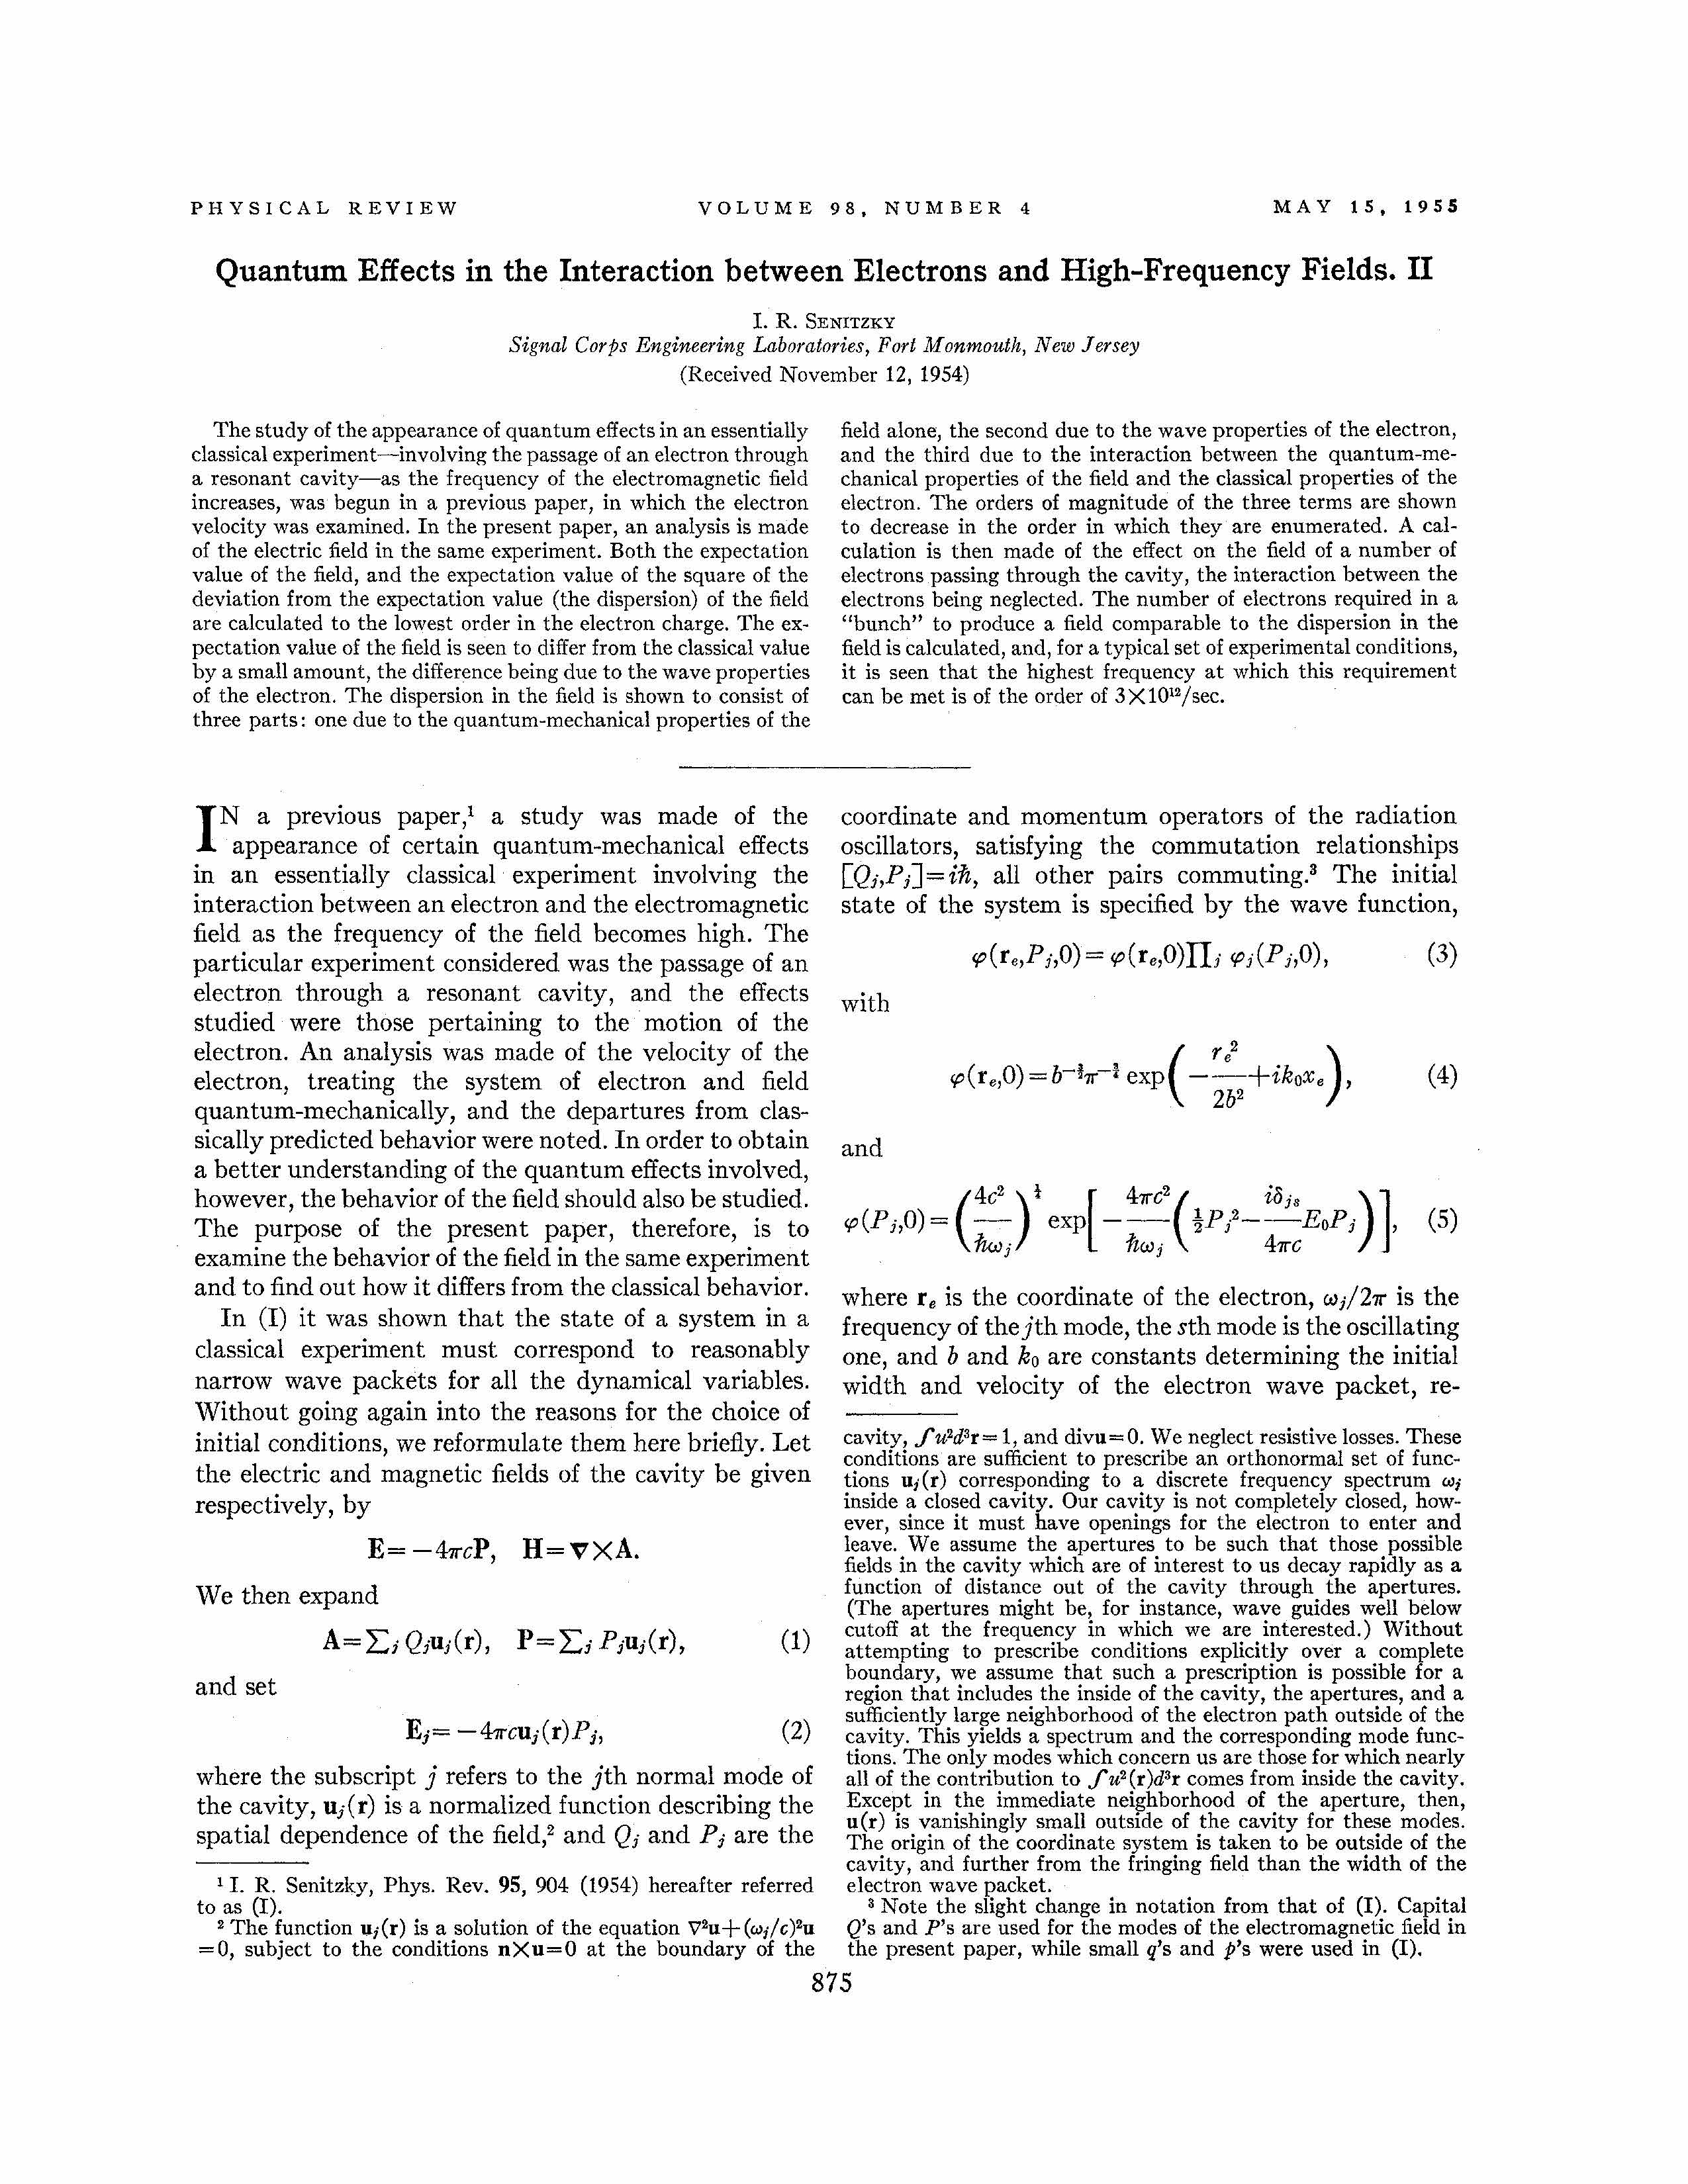

In [ ]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

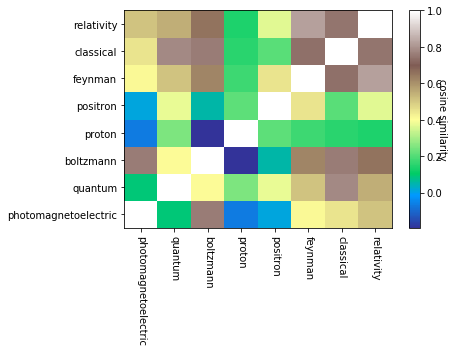

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

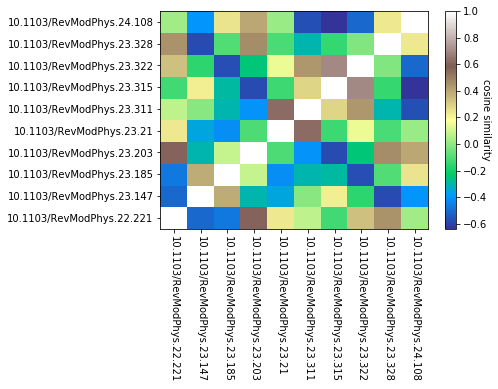

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

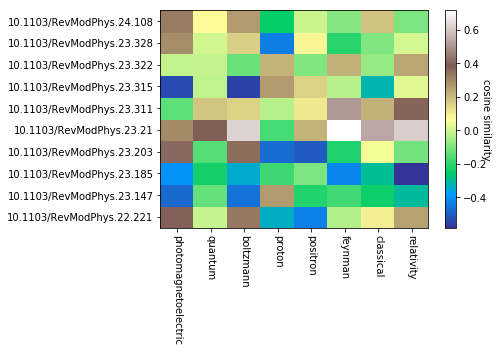

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

### Skip Thought

There exist many methods inspired by word2vec (and other embedding algorithms) which create embeddings for sentences and paragraphs. A notable method is skip-thought (Kiros et al, 2015) and the related FastSent which attempt to predict the entire sentence context based on the sentence in question. By doing this, sentences that share semantic and syntactic properties are mapped to similar vector representations. We do not explore this method in detail, but one can download the required model via the official GitHub repository, and use the model with just a few lines of code.

https://github.com/ryankiros/skip-thoughts

In [ ]:
# code to run model is in the GitHub link

### Word Mover's Distance and Embeddings

The last method we will explore in this section uses word embeddings to create distance measures between documents in a high dimensional space. Inspired by the Earth Mover’s (or discrete Wasserstein) Distance metric used to measure between points in space, Word Mover’s Distance (Kusner et al, 2015) measures the dissimilarity between two text documents as the minimum amount of distance that the embedded words of one document need to “travel” in the embedding space to reach the embedded words of another document. The best part of WMD is that we don’t need either of the sentences we compare to have any common words. Gensim’s implementation of Word Mover’s Distance works well and can be useful in building information retrieval systems built on word embeddings.

(code for WMD - https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html)

Building on this method, IBM built a sentence encoder inspired by WMD that goes beyond just distances in space towards encoding sentences using word embeddings and a distance measure. This embedding method is called Word Movers Embeddings, and there exists a C++ based python wrapper of the code, which we link to but do not demonstrate in this section.  Word mover embedding -  https://github.com/IBM/WordMoversEmbeddings


In [ ]:
# code to run models are in the GitHub link

## Classification and topic extraction with word embeddings

In this section we will explore the use of word and document embeddings for classification and topic extraction, two popular natural language processing tasks.

### Classification using Doc2vec

The last section in this tutorial will demonstrate some of the other powerful uses of word embeddings, such as document classification and topic extraction. A standard way to perform classification or clustering tasks for text documents is to use a machine learning (or deep learning) based method on the vectorised text documents, such as Naive Bayes or a Convolutional Neural Network. In the last section we saw a number of ways we can vectorise documents, and most of these would be pretty useful for classifying documents. 

In this section, we encourage you to visit these Gensim doc2vec tutorials which feature classification as one of the primary tasks. 

For more doc2vec examples:


[Gensim doc2vec code lee corpus](
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)

[Gensim doc2vec code imdb corpus](
https://radimrehurek.com/gensim/auto_examples/howtos/run_doc2vec_imdb.html#sphx-glr-auto-examples-howtos-run-doc2vec-imdb-py
)



A dataset that may be well suited for classification with doc2vec: 

[Yelp reviews](https://www.kaggle.com/c/yelp-recruiting/data?select=yelp_training_set.zip)

In [ ]:
# doc2vec classification code - build vectors using model, and set up a classification pipeline. 
# multiple links to code implementations provided.

### Inversion of Distributed Representations

But this isn’t the only way we can use word and document embeddings. Word embeddings are essentially distributed language models, and such a model can be inverted using bayesian techniques. What this means is that given a document, we can calculate the probability it was generated by a distributed model - by creating multiple word embedding models for each class, we are able to easily whip up a distribution of probabilities for a document belonging to each of these classes. This method of classification by inversion of distributed representations was first introduced by (Taddy 2015), and performed better than a doc2vec based classification on the dataset of Yelp reviews we just used.


#### The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [ ]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


### FastText Classification

Earlier in the homework we explored the word embedding method FastText, which is built using character n-grams or subwords. FastText can be very powerful for text classification, especially when we are dealing with many classes, partly due to its using Hierarchical Softmax for determining the probabilities a document belongs to a class, after averaging FastText embeddings of the words in a sentence or document. This is because a hierarchical algorithm follows a tree-like approach to determining the probabilities of the class, allowing for much faster computational times (hence, the fast part of the text). This allows for efficient text classification (performs as well as pure deep learning approaches) while being much faster. The code below, taken from the official documentation for FastText classification, demonstrates how to use the pre-trained vectors for the task.

FastText classification: https://fasttext.cc/docs/en/supervised-tutorial.html)


In [ ]:
# code for FastText classification

### Discourse Atoms

Another method also focuses on treating word embedding models as a generative process are Discourse Atoms, which are very similar to topic models. First described by Princeton NLP researchers ((Arora et al. 2016), (Arora et al. 2018)), the approach uses an idea of gist, or discourse as the process which generates text. These discourse atoms, similar to topic models, are defined as probabilities over words, and make it possible to measure similarities between the discourse vector and individual word vectors. While we won’t delve into the mathematical details of the generative process (a random walk over semantic space), what we do need to know is the steps to generate these discourse atoms for us. This is described well in one of the first social scientific papers to use these atoms for descriptive research (Arseniev-Koehler et al. 2020), and we adapt code used by them to create the atoms. The first major step is training word embeddings on the corpus in question.

#### imports

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
nytimes_w2v_model

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(nytimes_w2v_model, 150, 5, save=True)

In [ ]:
topic_diversity(nytimes_w2v_model, dictionary, top_n=25)

0.8885333333333333

In [ ]:
reconst_qual(nytimes_w2v_model, dictionary, alpha)


(2398540.8915694184, 0.894244689800385, 0.4193311633201203)

In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in nytimes_w2v_model.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


Discourse_Atom 0
['Egypts', 'Morsi', 'Morsi,', 'Morsis', 'Mubarak', 'Brotherhood', 'Egypt', 'Egyptian', 'ouster', 'coup', 'Islamist', 'Mohamed', 'Islamists', 'Egypt,', 'Cairo', 'generals', 'democratic', 'democracy.', 'ousted', 'legitimacy', 'Mahmoud', 'democracy', 'democracy,', 'Spring', 'Abdullah']


Discourse_Atom 1
['Derby', 'Triple', 'Belmont', 'Premier', 'Champions', 'Manchester', 'Crown', 'horse', 'League', 'winner,', 'horses', 'Real', 'Yankees', 'Yankees,', 'league', 'team', 'trainer', 'season', 'club', 'Chelsea', 'teams', 'Cup', 'Soccer', 'clubs', 'winning']


Discourse_Atom 2
['Brazil', 'Brazil,', 'Cup,', 'Cup', 'Germany', 'States,', 'countries', 'Cup.', 'Europe', 'Europe,', 'United', 'Portugal', 'countries,', 'nations,', 'Sweden', 'Argentina', 'Netherlands', 'World', 'Australia', 'Canada', 'Japan,', 'Africa', 'Germany,', 'States', 'Italy']


Discourse_Atom 3
['happened', 'moment', 'tragedy', 'story', 'happened.', 'tragic', 'nature', 'happened,', 'moments', 'truth', 'what', 'n

In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
nytimes_w2v_model.wv.similar_by_vector(dictionary[112],topn=25)

[('court', 0.7905327081680298),
 ('judge', 0.7822369337081909),
 ('Court', 0.7414460182189941),
 ('courts', 0.7331409454345703),
 ('judges', 0.7240278124809265),
 ('Supreme', 0.7147840261459351),
 ('ruling', 0.711248517036438),
 ('case', 0.7036005854606628),
 ('appeals', 0.6984674334526062),
 ('Judge', 0.6953557729721069),
 ('lawyers', 0.681331992149353),
 ('ruling,', 0.6630173921585083),
 ('judge,', 0.6567955613136292),
 ('court,', 0.6532109975814819),
 ('plaintiffs', 0.6437978148460388),
 ('justices', 0.6303653717041016),
 ('legal', 0.6270549297332764),
 ('case,', 0.6229175329208374),
 ('ruling.', 0.6145539879798889),
 ('Court,', 0.6115553379058838),
 ('Circuit', 0.6098675727844238),
 ('court.', 0.6063867211341858),
 ('case.', 0.6011309623718262),
 ('trial', 0.5913736820220947),
 ('Justice', 0.5887668132781982)]

In [ ]:
print(nytimes_w2v_model.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



1 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00273484 -0.00186215  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.00216819  0.          0.          0.          0.
  0.         -0.002954    0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0

# Homework

In this notebook, we went through many methods that use statistical models, shallow neural networks, or deep neural networks for natural language analysis. In the homework, you will try out these methods on your own textual data, using exploratory methods to understand your data, applying neural methods on them, and setting up pipelines to use these representations in different ways.

You will receive bonus points if the textual data you use is related to your group project or social and cultural analysis. There are a total of 6 questions with 2 sub parts each - you will be graded for 6/12 sub-parts, but are encouraged to give al of them a shot.

**1a)** Assemble a text corpus (collection of documents) of at least a 1000 distinct documents. The more data you have, the more effective your models will be.

In [ ]:
import pandas as pd

In [ ]:
wiki_df = pd.read_csv('wiki_movie_plots_deduped.csv')
#exclude unknown genres
wiki_df = wiki_df[~wiki_df['Genre'].isin(['Unknown', 'unknown'])]
#include only american movies
wiki_df = wiki_df[wiki_df['Origin/Ethnicity'] == 'American']

top_genres = wiki_df.groupby('Genre')[['Title']].count().sort_values('Title', ascending=False)[:10]

wiki_df = wiki_df[wiki_df['Genre'].isin(top_genres.index)]

In [ ]:
wiki_df = pd.concat([df[1].sample(n=300, random_state=1) for df in wiki_df.groupby('Genre')], ignore_index=True)

**1b)** What do you hope to analyse using this corpus? How is it related to your social scientific research question?

In [ ]:
hopes_and_dreams = 'Using this corpus - Im interested in exploring text similarity and clustering (do plots cluster naturally by Genre - can we predict a genre based on the plot description). Im generally really interested in classifications and semantic similarities in text so this exploration is transferrable to other interests of mine' #@param {type:"string"}

**2a)** Perform an exploratory data analysis on this collection of documents. Use any 2 of PCA/LSA, topic models, clustering, or visualisation techniques on your data for the exploration.

## LSA dimension reduction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap


In [ ]:
def plot_vectors(vectors, labels):
  #set up plot
  ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
  # get colors
  cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
  # plot first three dimensions
  sc = ax.scatter(vectors[:,0], vectors[:,1], vectors[:,2], c=labels, marker='o', alpha=1, cmap=cmap)
  ax.set_xlabel('one')
  ax.set_ylabel('two')
  ax.set_zlabel('three')
  plt.show()

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_texts = vectorizer.fit_transform(wiki_df['Plot']).toarray()

In [ ]:
svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [ ]:
lsa_texts = lsa.fit_transform(tfidf_texts)

In [ ]:
print(f"the dimensions of the tfidf text {len(tfidf_texts[0])} are now reduced to {len(lsa_texts[0])} dimensions") 

the dimensions of the tfidf text 40397 are now reduced to 5 dimensions


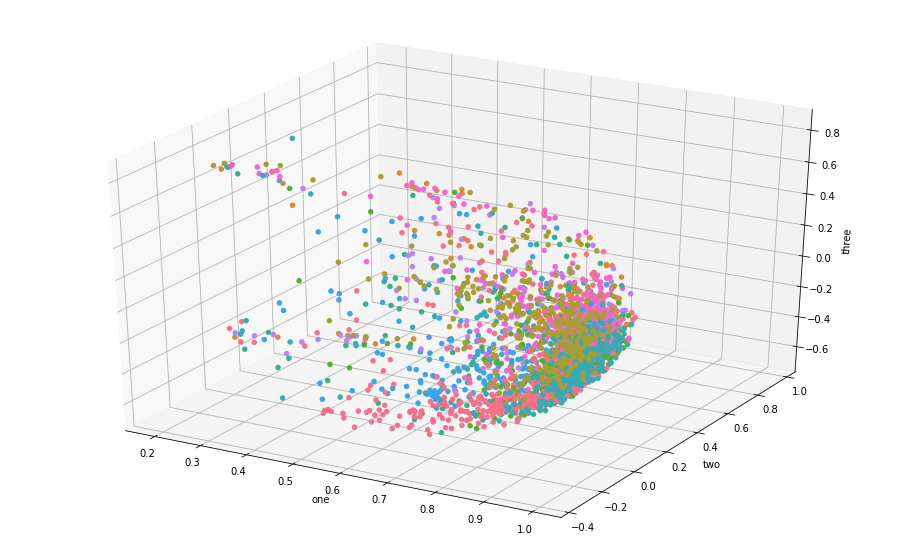

In [ ]:
genres = list(top_genres.index)
labels = wiki_df['Genre'].apply(genres.index)
plot_vectors(lsa_texts, labels)

## LDA Topic Models

In [ ]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_documents

In [ ]:
preprocessed_texts = preprocess_documents(wiki_df['Plot'])
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [ ]:
# investigate initial topics
ldamodel.print_topics()

[(0,
  '0.009*"kill" + 0.004*"ship" + 0.003*"escap" + 0.003*"return" + 0.003*"new" + 0.003*"attempt" + 0.003*"men" + 0.003*"leav" + 0.003*"crew" + 0.003*"man"'),
 (1,
  '0.007*"kill" + 0.004*"tell" + 0.004*"find" + 0.004*"car" + 0.004*"attack" + 0.004*"tom" + 0.003*"leav" + 0.003*"escap" + 0.003*"father" + 0.003*"return"'),
 (2,
  '0.007*"kill" + 0.004*"leav" + 0.003*"tell" + 0.003*"dai" + 0.003*"new" + 0.003*"time" + 0.003*"tri" + 0.003*"help" + 0.003*"find" + 0.003*"return"'),
 (3,
  '0.005*"kill" + 0.004*"tell" + 0.003*"take" + 0.003*"find" + 0.003*"return" + 0.003*"car" + 0.003*"attack" + 0.003*"leav" + 0.003*"friend" + 0.003*"arriv"'),
 (4,
  '0.006*"kill" + 0.005*"tell" + 0.004*"return" + 0.004*"leav" + 0.003*"frank" + 0.003*"alex" + 0.003*"murder" + 0.003*"new" + 0.003*"shoot" + 0.003*"escap"'),
 (5,
  '0.010*"kill" + 0.004*"tell" + 0.004*"man" + 0.003*"leav" + 0.003*"polic" + 0.003*"return" + 0.003*"hous" + 0.003*"time" + 0.003*"attack" + 0.003*"escap"'),
 (6,
  '0.005*"kill" +

We can also try
## Hierarchical Dirichlet Process
which uses similar methods used in LDA to identify the distribution of topics in a corpus, but is more flexible because it infers the number of topics from the corpus.

In [ ]:
from gensim.models import HdpModel

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.print_topics()

[(0,
  '0.007*kill + 0.004*tell + 0.004*leav + 0.003*return + 0.003*new + 0.003*man + 0.003*find + 0.003*time + 0.003*later + 0.003*hous'),
 (1,
  '0.007*kill + 0.004*tell + 0.004*leav + 0.003*return + 0.003*find + 0.003*new + 0.003*father + 0.003*home + 0.003*hous + 0.003*arriv'),
 (2,
  '0.005*kill + 0.003*tell + 0.003*new + 0.003*leav + 0.003*return + 0.002*polic + 0.002*car + 0.002*father + 0.002*friend + 0.002*find'),
 (3,
  '0.003*kill + 0.003*monei + 0.002*leav + 0.002*mccall + 0.002*crew + 0.002*father + 0.002*return + 0.002*school + 0.002*attempt + 0.002*man'),
 (4,
  '0.002*peter + 0.002*nick + 0.002*tarzan + 0.002*return + 0.002*sinbad + 0.002*dalton + 0.002*leav + 0.002*utah + 0.002*kill + 0.002*men'),
 (5,
  '0.003*kill + 0.002*lilli + 0.002*chri + 0.002*mcclane + 0.002*tell + 0.002*tom + 0.002*hannah + 0.001*tarzan + 0.001*vinero + 0.001*arriv'),
 (6,
  '0.002*kill + 0.002*diana + 0.002*wile + 0.002*sherman + 0.002*peabodi + 0.002*superman + 0.002*mondai + 0.001*doc + 0.0

**2b)** Which methods did you use? What did you learn? How will this guide your application of neural methods and representations?

In [ ]:
methods_and_lessons = 'It seems promising that for LSA we are able to reduce reduce the 40,397 dimensional vectors down to 5 dimensions but when we visualize that into a 3d space using Genre as a label, we see there isnt natural clustering (as I had hoped for from prior question) :( The topic models seem to have some topics that make sense - but they require human interpretation. I can imagine it would be interesting to use topics or word/topic embeddings as the input for clustering' #@param {type:"string"}

**3a)** Train a word2vec model on your dataset. Explore some of the relationships between words which are learned on your dataset.

Word2vec, much like methods like LSA which we saw earlier, is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2vmodel_cleaned = Word2Vec(
        preprocessed_texts,
        size=100,
        window=10)

In [ ]:
w2vmodel_cleaned.wv.most_similar("kill") #since this keeps appearing in the topic models

[('shot', 0.9289203882217407),
 ('shoot', 0.923659086227417),
 ('attempt', 0.9189292192459106),
 ('wound', 0.9156670570373535),
 ('gun', 0.8849557638168335),
 ('confront', 0.8844345211982727),
 ('stab', 0.8747183084487915),
 ('save', 0.8735147714614868),
 ('rainbird', 0.8713400363922119),
 ('boathous', 0.8663226962089539)]

In [ ]:
w2vmodel_cleaned.wv.most_similar("suspect") #well just roll with the crime movies

[('serial', 0.9675285816192627),
 ('case', 0.9600037336349487),
 ('stoke', 0.9511865377426147),
 ('pusher', 0.948928713798523),
 ('convict', 0.9489192962646484),
 ('simonson', 0.9400743246078491),
 ('crime', 0.9372438192367554),
 ('stefan', 0.9361187815666199),
 ('abdic', 0.9324297904968262),
 ('ybarra', 0.9322230815887451)]

In [ ]:
w2vmodel_cleaned.wv.most_similar("arrest") #catch the subject!!

[('detect', 0.9552952647209167),
 ('hellman', 0.9126785397529602),
 ('evid', 0.8976099491119385),
 ('offic', 0.894591212272644),
 ('polic', 0.8929380774497986),
 ('sheriff', 0.8895133137702942),
 ('investig', 0.8874602913856506),
 ('casel', 0.8771182298660278),
 ('cop', 0.8656395673751831),
 ('roenick', 0.8603209257125854)]

**3b)** Perform an advanced word embedding analysis, such as visualising embeddings, creating dynamic embeddings, projecting embeddings on distinct dimensions, debiasing, retrofitting, or aligning.

In [ ]:
import sklearn.decomposition
import sklearn.manifold

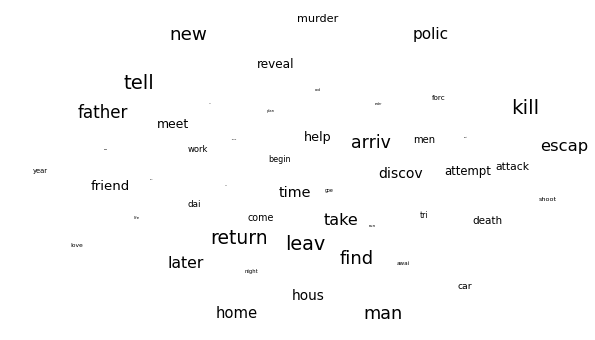

In [ ]:
numWords = 50
targetWords = w2vmodel_cleaned.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2vmodel_cleaned[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

**4a)** Use the spaCy language model's Computational Linguistics functions to explore 20 sentences in your documents from the corpora. 

In [ ]:
from spacy import displacy

In [ ]:
twenty_sents = wiki_df['Plot'][100].split('.')[:20]

In [ ]:
sents = [nlp(sent.strip()) for sent in twenty_sents]
for sent in sents: 
    displacy.render(sent, style='ent', jupyter=True)
    print('\n')

In [ ]:
for sent in sents[:5]: 
    displacy.render(sent, style='dep', jupyter=True)

**4b)** How do you think such methods can be useful in your social scientific research? 
Hint: think of what different parts of speech or entities might entail!

In [ ]:
comp_ling_possibilities = 'What immediately jumped out to me in the topic model were VERBS - I think actions are likely very indicative of movie type / genre. I can imagine capitalizing on spacy POS tagging to pull out the verbs of a plot description and weighting those more highly in a genre predicting application' #@param {type:"string"}

**5a)** Create 3 different neural representations of each of the documents in your corpus.

**5b)** Compare between a subset of documents for each of these representations and calculate similarities between documents.

**6a)** Use these representations of documents to perform a classification task on your data based on labels or possible natural categories.

**6b)** Use either the inverse of distributed representations or discourse atoms on your dataset.